# Прогноз стоимости подержанных автомобилей

## Содержание

**[1. Обзор данных](#1)**

- **[1.1 Ввод необходимых функций](#1.1)**
- **[1.2 Разведочный анализ данных](#1.2)**
- **[1.3 Общие выводы по качеству имеющихся данных](#1.3)**


**[2. Подготовка данных](#2)**

- **[2.1. Предобработка данных](#2.1)**
- **[2.2. Проверка данных на мультиколлинеарность](#2.2)**
- **[2.3. Общие выводы по подготовке данных ](#2.3)**


**[3. Обучение моделей](#3)**

- **[3.1. Пробразование категорий в число](#3.1)**
- **[3.2. Проверка метода word_str. Объединение значений символов](#3.2)**
- **[3.3. Проверка метода word_int. Сумма значений символов](#3.3)**
- **[3.4. Модель линейной регрессии](#3.4)**
- **[3.5. Модель Решающего дерева](#3.5)**
- **[3.6. Методы улучшения качества моделей](#3.6)**
- **[3.7. Общие выводы](#3.7)**


**[4. Подготовка контрольного датасета](#4)**

Многие знают про маркетплейсы где продаются б/у вещи, на которых есть возможность недорого купить качественную и полезную вещь. Но всегда волнует вопрос - кто и как устанавливает цену, и какие его характеристики больше всего влияют на итоговую стоимость продажи?! Вопрос становиться особо актуальным, если речь идет про дорогие товары, например про автомобили!

Предлагаем вам принять участие в Мастерской, в рамках которой вы сможете поработать с данными о продажах автомобилей на вторичном рынке. Целью вашего проекта будет разработанная модель предсказания стоимости автомобиля на вторичном рынке.

Основной критерий победы в соревновании - точность предсказания.

**Соревнование на платформе Kaggle.** Стоимость поддержанного автомобиля. Предскажи стоимость автомобиля на вторичном рынке.

**Цель Соревнования.** Разработка модели, которая достигнет наилучшего значения показателя `MAPE` (Mean Absolute Percentage Error).

**Цель исследования.** Построить модель для определения стоимости автомобиля с высоким качеством предсказания.

**Задачи:**
- загрузить и ознакомится с данными,
- провести предварительную обработку,
- сделать полноценный разведочный анализ,
- разработать новые синтетические признаки,
- проверить на мультиколлинеарность,
- сделать отбор финального набора обучающих признаков,
- выбрать и обучить модели,
- провести итоговую оценку качества предсказания лучшей модели,
- сделать анализ важности признаков модели.

**Входные данные.** Три файла в формате `.csv` с данными о продаваемых машинах:
1. `train.csv` - информация о характеристиках автомобилей (~440000), которые будут использоваться в качестве обучающих данных.
2. `test.csv` - информация о характеристиках автомобилей (~110000), которые будут использоваться в качестве тестовых данных.
3. `sample_submission.csv` - пример файла предсказаний в правильном формате.

**Формальная задача.** Предсказать значение `'sellingprice'` для каждого автомобиля из датасета `test.csv`.

**Ожидаемый результат.** Построена модель для определения стоимости автомобиля, со значением метрики `MAPE` не более **15**.


## Обзор данных <a id='1'></a>

**Признаки**

- `year` – год выпуска автомобиля.
- `make` – марка автомобиля.
- `model` – модель автомобиля определенной марки.
- `trim` – уровень отделки салона автомобиля.
- `body` – тип кузова транспортного средства.
- `transmission` – тип коробки передач.
- `vin` – идентификационный номер транспортного средства.
- `state` – состояние, в котором автомобиль выставлен на аукцион.
- `condition` – оценка состояние автомобилей на момент аукциона.
- `odometer` – расстояние, пройденное автомобилем с момента выпуска.
- `color` – цвет кузова автомобиля.
- `interior` – цвет салона автомобиля.
- `seller` – продавец автомобиля, автосалоны.
- `saledate` – дата продажи автомобиля. 

**Целевой признак**

- `sellingprice` – цена, по которой автомобиль был продан на аукционе.

In [1]:
# Импорт библиотек
import pandas as pd
import os
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
from numpy.random import RandomState
from time import time

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_percentage_error

import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

In [2]:
# Введем константу
state = RandomState(12345)

### Ввод необходимых функций <a id='1.1'></a>

In [3]:
# Функция исследования датасета
def info_df(df_name):
    st = df_name.shape[0]
    col = df_name.shape[1]
    zerro = df_name.isna().sum()
    vin = len(df_name['vin'].unique())
    print(f'Размер таблиы: {col} столбцов и {st} строк')
    print(f'Общее количество пропусков - {zerro.sum()}')
    print(df_name.isna().sum())
    print()
    print(f'Количество явных дубликатов: {df_name.duplicated().sum()}')
    print(f'Количество уникальных VIN: {vin}')
    print()
    print(df_name.info())
    print()
    display(df_name.describe().round(2))

In [4]:
# Функция построения типовых гистограмм
def hist_pattern(df, title):
    df.hist(bins=50, figsize=(6,4))
    plt.title(title)
    return plt.show()


In [5]:
# Функция преобразования слова в число
def word_int(word):
    list_word = list(word) # Преобразуем слово в список
    list_int = [] 
    
    # Преобразуем каждую букву списка в число
    for i in range(len(list_word)):
        list_int.append((i+1)*ord(list_word[i]))
    
    return sum(list_int) # вернем сумму чисел

In [6]:
# Функция преобразования слова в строку чисел
def word_str(word):
    list_word = list(word) # Преобразуем слово в список
    list_str = [] 
    
    # Преобразуем каждую букву списка в число строкового типа 
    for i in range(len(list_word)):
        list_str.append(str((i+1)*ord(list_word[i])))
    
    return int(''.join(list_str)) # вернем строку чисел

In [7]:
# Функция преобразования месяца в время года
# 1 - Зима
# 2 - Весна
# 3 - Лето
# 4 - Осень

def season(month):
    if month in [1, 2, 12]:
        return 1
    elif month in [3, 4, 5]:
        return 2
    elif month in [6, 7, 8]:
        return 3
    elif month in [9, 10, 11]:
        return 4
        

### Разведочный анализ данных <a id='1.2'></a>

In [8]:
# Чтение файлов
path = 'C:\\Users\\User\\first_notebook\\Praktikum\\auto_prixe_predict\\'

df_train = pd.read_csv(path + 'train.csv')
df_test = pd.read_csv(path + 'test.csv')
df_sample = pd.read_csv(path + 'sample_submission.csv')


In [10]:
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,saledate
0,2011,Ford,Edge,SEL,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,Tue Jun 02 2015 02:30:00 GMT-0700 (PDT)
1,2014,Ford,Fusion,SE,Sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,Wed Feb 25 2015 02:00:00 GMT-0800 (PST)
2,2012,Nissan,Sentra,2.0 SL,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,Wed Jun 10 2015 02:30:00 GMT-0700 (PDT)


In [11]:
# Обследуем данные
info_df(df_train)

Размер таблиы: 15 столбцов и 440236 строк
Общее количество пропусков - 97003
year                0
make             8043
model            8123
trim             8337
body            10393
transmission    51461
vin                 0
state               0
condition        9405
odometer           69
color             586
interior          586
seller              0
sellingprice        0
saledate            0
dtype: int64

Количество явных дубликатов: 0
Количество уникальных VIN: 440236

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   year          440236 non-null  int64  
 1   make          432193 non-null  object 
 2   model         432113 non-null  object 
 3   trim          431899 non-null  object 
 4   body          429843 non-null  object 
 5   transmission  388775 non-null  object 
 6   vin           440236 non-null  object 
 7   s

,year,condition,odometer,sellingprice
count,440236.00,430831.00,440167.00,440236.00
mean,2010.04,3.43,68344.42,13592.21
std,3.98,0.95,53542.20,9751.48
min,1982.00,1.00,1.00,1.00
25%,2007.00,2.70,28258.00,6900.00
50%,2012.00,3.60,52098.00,12100.00
75%,2013.00,4.20,99272.00,18200.00
max,2015.00,5.00,999999.00,230000.00


**Расмотрим данные по году выпуска**

In [12]:
# Исследуем год выпуска
df_train['year'].unique()

array([2011, 2014, 2012, 2003, 2007, 2013, 2010, 2000, 2005, 2006, 2004,
       2008, 2009, 2015, 2002, 2001, 1999, 1998, 1996, 1997, 1994, 1995,
       1993, 1989, 1991, 1988, 1987, 1990, 1992, 1985, 1986, 1983, 1984,
       1982], dtype=int64)

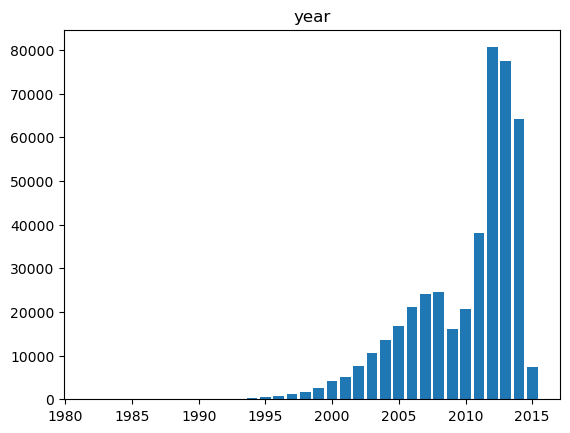

In [13]:
years = df_train['year'].value_counts().index
counts = df_train['year'].value_counts().values


plt.bar(years, counts)
plt.title('year')
plt.show()

<Axes: xlabel='sellingprice', ylabel='year'>

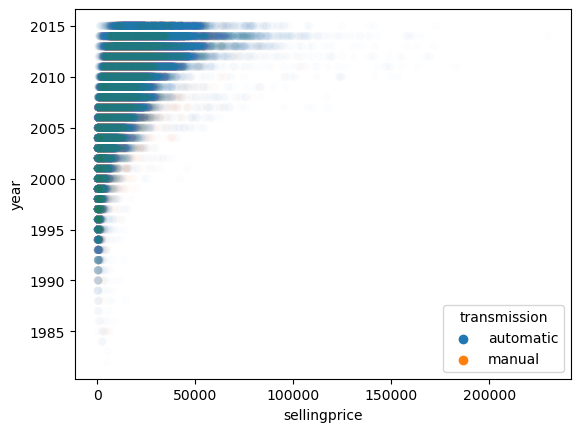

In [14]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="year", 
    hue="transmission",
    alpha=0.01
)

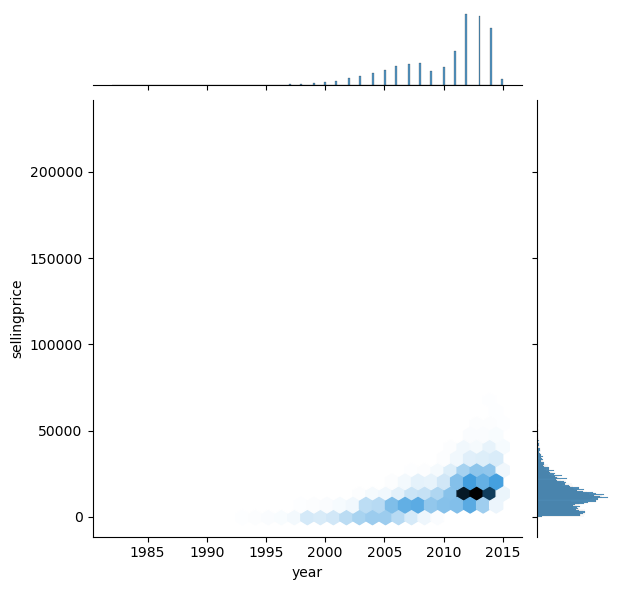

In [15]:
sns.jointplot(x="year", y="sellingprice", data=df_train, kind='hex', gridsize=30)

In [16]:
df_train_year = df_train.groupby('year').agg({
    'sellingprice': ['mean', 'median']
})
df_train_year.columns = ['mean_year', 'median_year']
df_train_year['year'] = df_train_year.index
df_train_year = df_train_year.reset_index(drop=True)

In [17]:
df_train_year.head(3)

,mean_year,median_year,year
0,5000.0,5000.0,1982
1,5250.0,5250.0,1983
2,2425.0,2400.0,1984


In [18]:
year_gr = df_train_year['year']
mean_year = df_train_year['mean_year']
median_year = df_train_year['median_year']

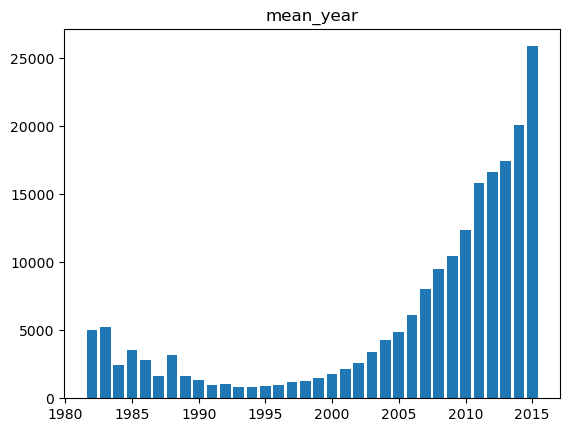

In [19]:
plt.bar(year_gr, mean_year)
plt.title('mean_year')
plt.show()

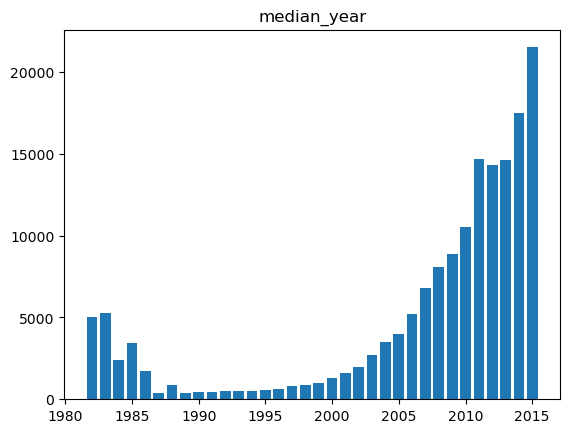

In [20]:
plt.bar(year_gr, median_year)
plt.title('median_year')
plt.show()

**Расмотрим данные по состоянию автомобиля**

In [21]:
# Исследуем состояние автомобиля
df_train['condition'].unique()

array([4.2, 3.5, 2.2, 2.8, 2. , 2.5, 3.4, 4.8, 1.9, 1. , 3.1, 2.7, 3.6,
       2.9, 4.1, 2.6, 2.1, 3. , 4.9, 4.7, 4. , 3.3, 3.8, 3.7, 4.5, 4.6,
       5. , 4.3, 2.4, 2.3, 3.9, nan, 3.2, 4.4, 1.4, 1.5, 1.7, 1.2, 1.3,
       1.6, 1.8, 1.1])

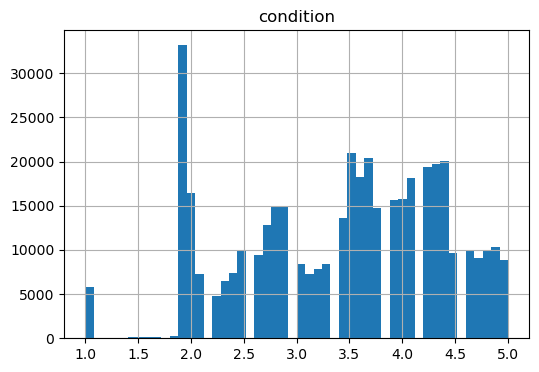

In [22]:
hist_pattern(df_train['condition'], 'condition')

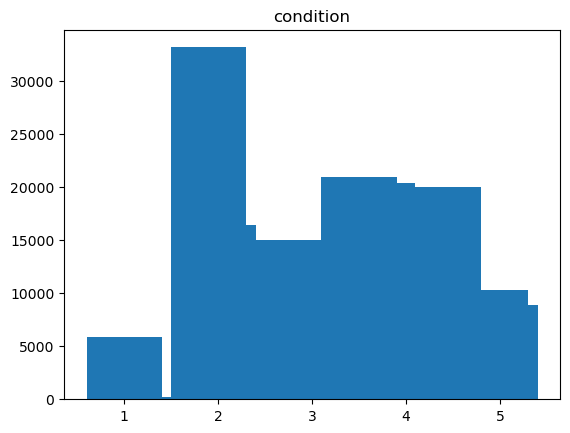

In [23]:
condition = df_train['condition'].value_counts().index
counts = df_train['condition'].value_counts().values


plt.bar(condition, counts)
plt.title('condition')
plt.show()

<Axes: xlabel='sellingprice', ylabel='condition'>

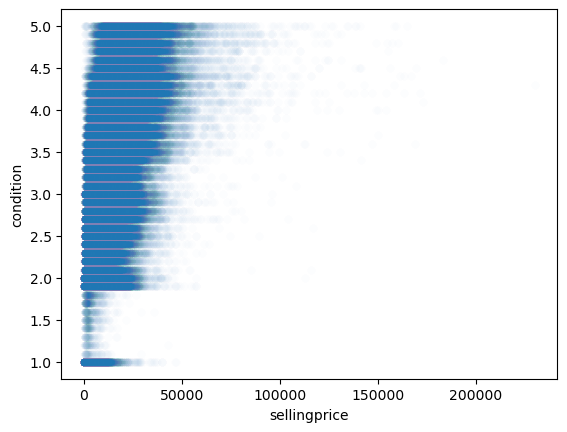

In [24]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="condition",
    alpha=0.01
)

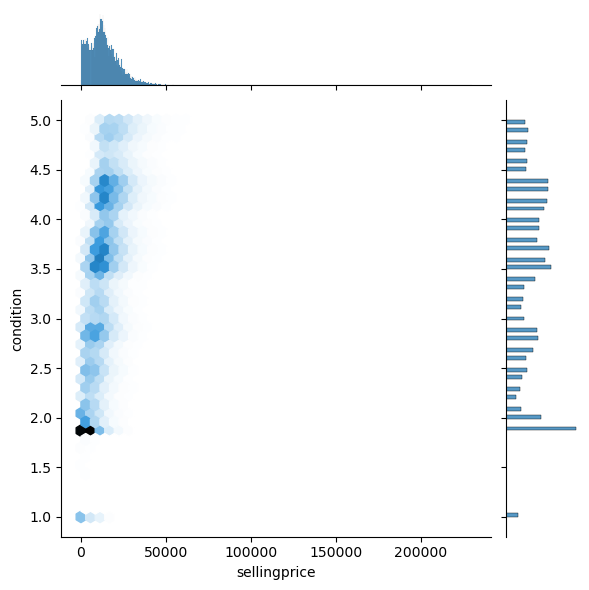

In [25]:
sns.jointplot(x="sellingprice", y="condition", data=df_train, kind='hex', gridsize=41)

**Расмотрим данные по пробегу автомобиля**

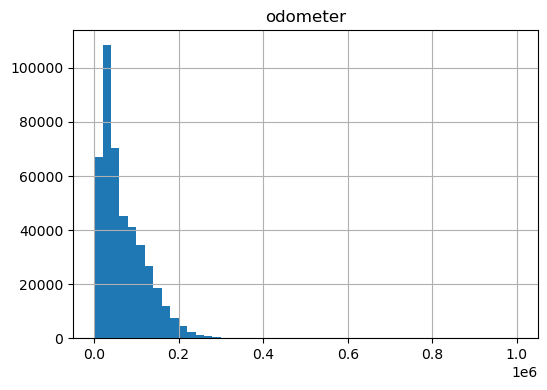

In [26]:
hist_pattern(df_train['odometer'], 'odometer')

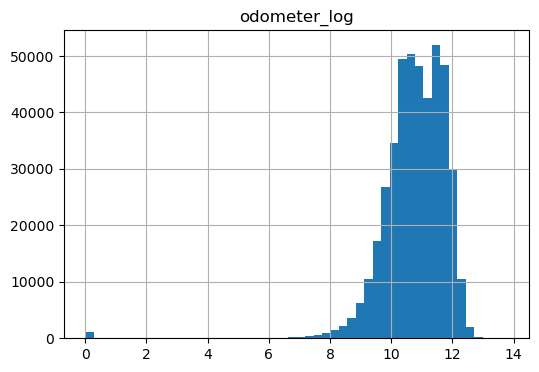

In [27]:
hist_pattern(np.log(df_train['odometer']), 'odometer_log')

<Axes: xlabel='sellingprice', ylabel='odometer'>

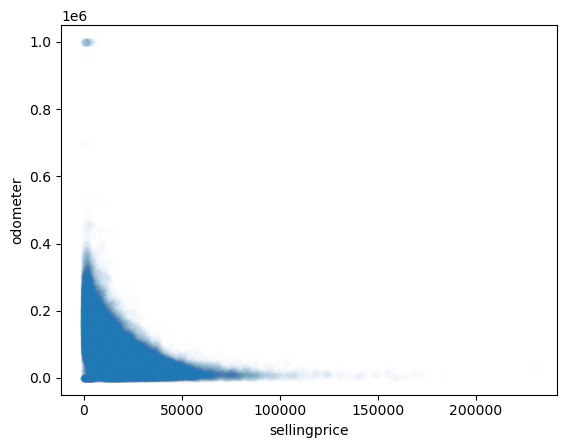

In [28]:
sns.scatterplot(
    data=df_train, 
    x="sellingprice", 
    y="odometer",
    alpha=0.01
)

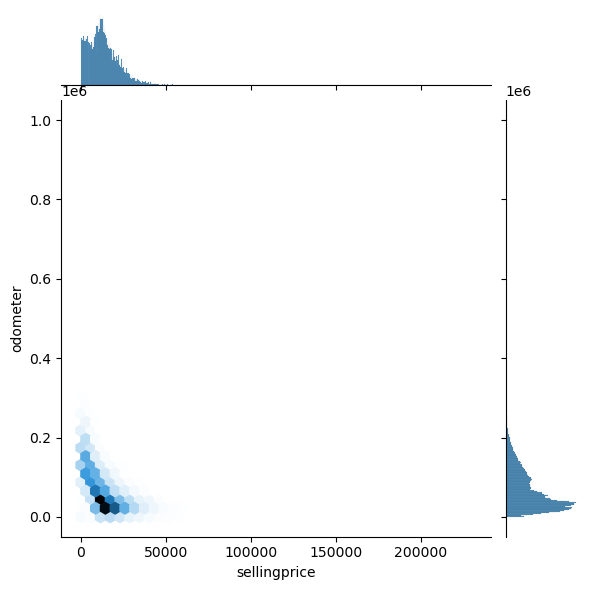

In [29]:
sns.jointplot(x="sellingprice", y="odometer", data=df_train, kind='hex', gridsize=40)

**Расмотрим данные по цене автомобиля**

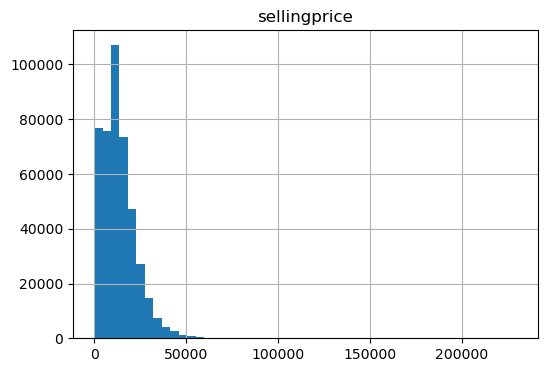

In [30]:
hist_pattern(df_train['sellingprice'], 'sellingprice')

In [31]:
# Определим состав признака sellingprice
df_train['sellingprice'].value_counts().sort_index()

sellingprice
1          2
100       16
125        1
150       18
175       10
          ..
169500     1
171500     1
173000     1
183000     1
230000     1
Name: count, Length: 1735, dtype: int64

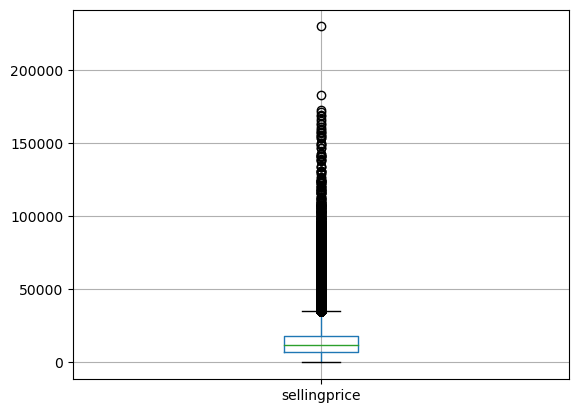

In [32]:
# Изобразим выбросы на графике
df_train.loc[:, ['sellingprice']].boxplot()
plt.show()

In [33]:
# Определим верхний уровень выбросов
price_mean = df_train['sellingprice'].mean()
price_std = np.std(list(df_train['sellingprice']), ddof=1)
sig_max = price_mean + 3 * price_std
print('Верхний уровень выброса - ', sig_max)

Верхний уровень выброса -  42846.64688071322


In [34]:
# Определим нижний уровень выбросов
print('Нижний уровень выброса - ', df_train['sellingprice'].quantile(0.05))

Нижний уровень выброса -  1500.0


In [35]:
price_list = df_train['sellingprice'].value_counts().sort_index()
print('Количество нижних выбросов', price_list[price_list.index < 1500].sum())
print('Количество верхних выбросов', price_list[price_list.index > 42846].sum())

Количество нижних выбросов 21223
Количество верхних выбросов 5446


Судя по графику и значению квантиля 5% – выбросом является цены со значением менее 1 500 (21 223 повторения).

Используя правило трех сигм определена верхняя граница выброса – 42 846 (5 446 повторений)

In [36]:
# Определим состав признака odometer
df_train['odometer'].value_counts().sort_index()

odometer
1.0         1059
2.0           11
3.0            6
4.0            8
5.0            8
            ... 
537334.0       1
694978.0       2
959276.0       1
980113.0       1
999999.0      55
Name: count, Length: 159364, dtype: int64

In [37]:
odometer_list = df_train['odometer'].value_counts().sort_index()
print('Количество данных верхнего выброса', odometer_list[odometer_list.index > 500000].sum())

Количество данных верхнего выброса 62


In [38]:
# Список категориальных признаков
list_clusters = ['make', 'model', 'trim', 'body', 'transmission', 'state', 'color', 'interior', 'seller']

In [39]:
# Число уникальных значений в каждлом категориальном столбце
for i in list_clusters:
    print(i, '-', len(df_train[i].unique()))

make - 93
model - 960
trim - 1923
body - 86
transmission - 3
state - 38
color - 21
interior - 18
seller - 13025


### Общие выводы по качеству имеющихся данных <a id='1.3'></a>

Датасет содержит `15` столбцов и `440 236` строк. Общее число пропусков `97 003`.

Основные показатели датасета имеют отклонения от нормального распределения. 

Данные по годам выпуска автомобилей (`year`) смещены вправо. В основном, на рынке представлены автомобили с `2010` по `2015` гг. Есть ряд данных до `1995` года, которые могут считаться аномалиями. Стоимость таких автомобилей очень низкая и они будут оказывать отрицательное влияние на обучение модели. Из графика также видно очень незначительное количество автомобилей с ручной коробкой передач. Такой перекос данных также окажет негативное влияние на итоговую оценку. При этом, имеет место зависимость между ценой продажи и годом, что наглядно показано на графике.

Параметр состояния автомобиля (`condition`) также коррелирует с ценой продажи, но в отличии от года выпуска имеет более равномерное распределение (низкую степень смещения показывает незначительное отклонение среднего значения от медианы). Это позволит эффективно применить данный параметр для прогнозирования. Необходимо изменить тип данного параметра на действительное число.

Данные о пробеге машины (`odometer`) значительно смещены влево. Среднее значительно превышает медианное значение. При этом разброс значений очень значимый. Параметр содержит аномальные значения, которые нельзя удалять для избегания переобучения модели.

Цена продажи (`sellingprice`), так же существенно смещена влево. Параметр содержит определенное количество аномальных значений. Значение квантиля `5%` показало, что выбросом являются цены со значением менее `1 500` (`21 223` повторения). Используя правило трех сигм, определена верхняя граница выброса – `42 846` (`5 446` повторений). Тем не менее, для избегания переобучения модели, выбросы удалять не будем.

Данные о дате продажи не приведены в тип `data`. Кроме того, есть предположение, что на прогнозирование цены могут влиять параметры месяца, дня недели, времени года.

Показатель `vin` можно использовать для уточнения параметров автомобиля, взяв для это `4-9` цифру `vin`.

В связи с тем, что на контрольном датасете ни каких удалений делать нельзя, то убирать выбросы из обучающего датасета не целесообразно, поскольку это может привести к переобучению модели.

## Подготовка данных <a id='2'></a>

### Предобработка данных <a id='2.1'></a>

**План по предобработке данных**

- Преобразуем дату продажи в формат datetime
- Создать столбцы месяц, день месяца, день недели, времени года, возраст автомобиля
- Преобразовать condition в тип float
- Добавить уникальный класс модели по vin
- Заполнить пропуски: мелианным значением по году для числовых и no_answ для категориальных
- Привести все категориальные признаки в нижний регистр

In [40]:
# Преобразуем дату продажи в формат datetime
df_train['saledate'] = df_train['saledate'].apply(lambda x: ' '.join(x.split()[:-2]))
df_train['saledate'] = pd.to_datetime(df_train['saledate'], format='%a %b %d %Y %H:%M:%S')

# создадим столбцы месяц, день месяца, день недели
df_train['month'] = df_train['saledate'].dt.month
df_train['month_day'] = df_train['saledate'].dt.day
df_train['week_day'] = df_train['saledate'].dt.weekday

# создадим стобец времени года
df_train['season'] = df_train['month'].apply(season)

# создадим стобец возраста автомобиля
df_train['age'] = df_train['saledate'].dt.year - df_train['year']

# Преобразуем condition в тип float
df_train['condition'] = df_train['condition'].astype('float')

# Добавим уникальный класс модели по vin
df_train['vin_sh'] = df_train['vin'].apply(lambda x: x[3:9])

In [41]:
# Заполнение пропусков
# Для числовых признаков - медианное занчение по году 
# Для категориальных признаков - no_answ

# Введем значения мединан по году
df_train['year_odometer'] = df_train.groupby('year')['odometer'].transform('median')
df_train['year_condition'] = df_train.groupby('year')['condition'].transform('median')

# Заполним пропуски
df_train['odometer'] = df_train['odometer'].fillna(df_train['year_odometer'])
df_train['condition'] = df_train['condition'].fillna(df_train['year_condition'])
df_train = df_train.fillna('no_answ')

# Удалим столбцы
df_train.drop(['year_odometer', 'year_condition'], axis=1, inplace=True)

In [42]:
# Проверка пропусков
df_train.isna().sum()

year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
month           0
month_day       0
week_day        0
season          0
age             0
vin_sh          0
dtype: int64

In [43]:
# Обновим список категориальных признаков
list_clusters.append('vin_sh')
list_clusters

['make',
 'model',
 'trim',
 'body',
 'transmission',
 'state',
 'color',
 'interior',
 'seller',
 'vin_sh']

In [44]:
# Все категориальные признаки приведем в нижний регистр
for i in list_clusters:
    df_train[i] = df_train[i].apply(lambda x: x.lower())

In [45]:
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,...,interior,seller,sellingprice,saledate,month,month_day,week_day,season,age,vin_sh
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,...,black,santander consumer,12500,2015-06-02 02:30:00,6,2,1,3,4,dk3jc4
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,...,black,ars/avis budget group,14500,2015-02-25 02:00:00,2,25,2,1,1,6p0h75
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,...,black,nissan-infiniti lt,9100,2015-06-10 02:30:00,6,10,2,3,3,ab6ap4


In [46]:
info_df(df_train)

Размер таблиы: 21 столбцов и 440236 строк
Общее количество пропусков - 0
year            0
make            0
model           0
trim            0
body            0
transmission    0
vin             0
state           0
condition       0
odometer        0
color           0
interior        0
seller          0
sellingprice    0
saledate        0
month           0
month_day       0
week_day        0
season          0
age             0
vin_sh          0
dtype: int64

Количество явных дубликатов: 0
Количество уникальных VIN: 440236

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440236 entries, 0 to 440235
Data columns (total 21 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   year          440236 non-null  int64         
 1   make          440236 non-null  object        
 2   model         440236 non-null  object        
 3   trim          440236 non-null  object        
 4   body          440236 non-null  object        
 

,year,condition,odometer,sellingprice,saledate,month,month_day,week_day,season,age
count,440236.00,440236.00,440236.00,440236.00,440236,440236.00,440236.00,440236.00,440236.00,440236.00
mean,2010.04,3.41,68353.18,13592.21,2015-03-06 07:37:27.278414592,3.82,15.42,2.14,1.54,4.86
min,1982.00,1.00,1.00,1.00,2014-01-01 09:15:00,1.00,1.00,0.00,1.00,-1.00
25%,2007.00,2.70,28259.00,6900.00,2015-01-21 02:00:00,1.00,8.00,1.00,1.00,2.00
50%,2012.00,3.60,52103.50,12100.00,2015-02-13 01:15:00,2.00,16.00,2.00,1.00,3.00
75%,2013.00,4.20,99283.00,18200.00,2015-05-22 02:00:00,6.00,22.00,3.00,2.00,7.00
max,2015.00,5.00,999999.00,230000.00,2015-07-21 02:30:00,12.00,31.00,6.00,3.00,33.00
std,3.98,0.95,53544.82,9751.48,NaN,3.25,8.54,1.04,0.78,3.95


### Проверка данных на мультиколлинеарность <a id='2.2'></a>

In [47]:
# Проведем корреляционный анализ
df_corr = df_train.drop('vin', axis=1)
df_corr.corr(numeric_only=True).loc[:, 'sellingprice'].sort_values(ascending=False)

sellingprice    1.000000
year            0.586847
condition       0.545219
week_day        0.084767
season          0.071614
month_day      -0.004659
month          -0.031276
odometer       -0.583119
age            -0.584540
Name: sellingprice, dtype: float64

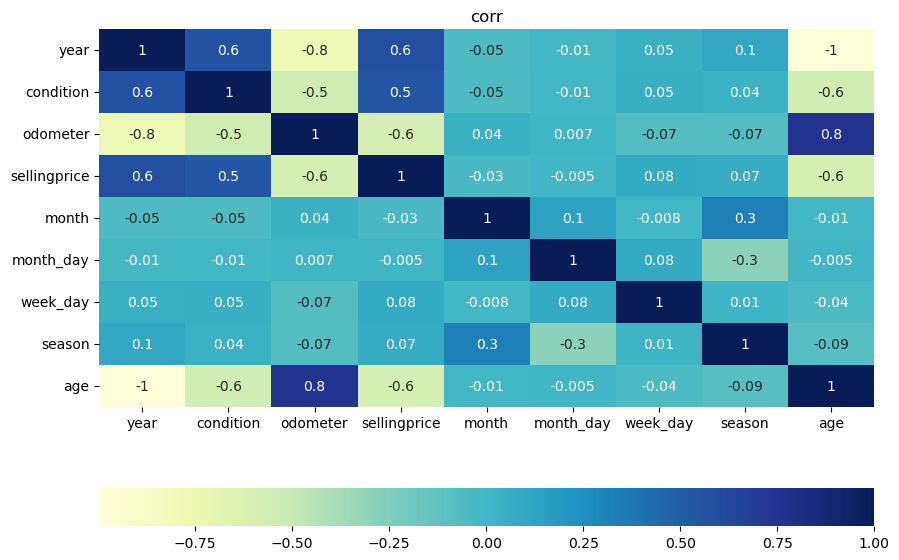

In [48]:
# Построим тепловую карту
plt.figure(figsize=(10, 7))
df_plot = sns.heatmap(df_corr.corr(numeric_only=True), cmap="YlGnBu", annot=True, fmt='.1g',
                     cbar_kws= {'orientation': 'horizontal'})
plt.title('corr')
plt.show()

In [49]:
# Удалим столбцы week_day, month_day, month, age, saledate из признаков
df_train.drop(['week_day', 'month_day', 'month', 'age', 'saledate'], axis=1, inplace=True)
df_train.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,sellingprice,season,vin_sh
0,2011,ford,edge,sel,suv,automatic,2fmdk3jc4bba41556,md,4.2,111041.0,black,black,santander consumer,12500,3,dk3jc4
1,2014,ford,fusion,se,sedan,automatic,3fa6p0h75er208976,mo,3.5,31034.0,black,black,ars/avis budget group,14500,1,6p0h75
2,2012,nissan,sentra,2.0 sl,sedan,automatic,3n1ab6ap4cl698412,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,3,ab6ap4


In [50]:
# Столбец vin сделаем индексом
df_train = df_train.set_index('vin')
df_train.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,sellingprice,season,vin_sh
vin,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,2011,ford,edge,sel,suv,automatic,md,4.2,111041.0,black,black,santander consumer,12500,3,dk3jc4
3fa6p0h75er208976,2014,ford,fusion,se,sedan,automatic,mo,3.5,31034.0,black,black,ars/avis budget group,14500,1,6p0h75
3n1ab6ap4cl698412,2012,nissan,sentra,2.0 sl,sedan,automatic,nj,2.2,35619.0,black,black,nissan-infiniti lt,9100,3,ab6ap4


### Общие выводы по подготовке данных <a id='2.3'></a>

Сформирован сбалансированный набор показателей для эффективного прогнозирования цены продажи автомобиля.

По результату корреляционного анализа, не выявлена зависимость цены продажи ни с одним из показателей даты кроме сезона.

Проверка данных на мультиколлинеарность показала наличие параметров с высоким уровнем пересекающейся корреляции. Снижение уровня мультиколлинеарности было достигнуто удалением следующих параметров: `week_day`, `month_day`, `month`, `age`. Кроме того, отсутствует необходимость в параметре `saledate`.

Для обеспечения однозначной идентификации автомобиля, показатель `vin` вынесен в индекс датасета.

## Обучение моделей <a id='3'></a>

### Пробразование категорий в число <a id='3.1'></a>

In [51]:
# Списки измнения категориальных параметров и добавления числовых
list_in = ['make', 'model', 'body', 'transmission',  'state', 'color', 'interior', 'seller', 'trim', 'vin_sh']
list_out_i = [item + '_numi' for item in list_in]
list_out_s = [item + '_nums' for item in list_in]
list_num = ['year', 'condition', 'odometer', 'sellingprice', 'season']

In [52]:
%%time
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_int
df_train_short = pd.DataFrame()

for i in range(len(list_in)):
    df_train_short[list_out_i[i]] = df_train[list_in[i]].apply(word_int)

for i in range(len(list_num)):
    df_train_short[list_num[i]] = df_train[list_num[i]]


CPU times: total: 24.8 s
Wall time: 24.8 s


In [53]:
df_train_short.head(3)

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,sellingprice,season
vin,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,1066,1014,703,4793,309,1536,1536,17831,641,1698,2011,4.2,111041.0,12500,3
3fa6p0h75er208976,1066,2316,1555,4793,331,1536,1536,23070,317,1431,2014,3.5,31034.0,14500,1
3n1ab6ap4cl698412,2270,2263,1555,4793,322,1536,1536,16910,1637,1715,2012,2.2,35619.0,9100,3


In [54]:
%%time
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_str
df_train_long = pd.DataFrame()

for i in range(len(list_in)):
    df_train_long[list_out_s[i]] = df_train[list_in[i]].apply(word_str)

for i in range(len(list_num)):
    df_train_long[list_num[i]] = df_train[list_num[i]]


CPU times: total: 43.8 s
Wall time: 44.2 s


In [55]:
df_train_long.head(3)

,make_nums,model_nums,body_nums,transmission_nums,state_nums,color_nums,interior_nums,seller_nums,trim_nums,vin_sh_nums,year,condition,odometer,sellingprice,season
vin,,,,,,,,,,,,,,,
2fmdk3jc4bba41556,102222342400,101200309404,115234354,97234348444545582812840891,109200,98216291396535,98216291396535,1151943304644856607008081026320108913321430161...,115202324,100214153424495312,2011,4.2,111041.0,12500,3
3fa6p0h75er208976,102222342400,102234345420555660,115202300388550,97234348444545582812840891,109222,98216291396535,98216291396535,9722834518848570873592028898012871200133914141...,115202,54224144416275318,2014,3.5,31034.0,14500,1
3n1ab6ap4cl698412,110210345460485660,115202330464570582,115202300388550,97234348444545582812840891,110212,98216291396535,98216291396535,1102103454604856603158409901020115513201365162...,5092144128575648,97196162388560312,2012,2.2,35619.0,9100,3


### Проверка метода word_str. Объединение значений символов <a id='3.2'></a>

In [56]:
# Разделим таблицу на признаки и целевые результаты
features_long = df_train_long.drop(['sellingprice'], axis=1)
target_long = df_train_long['sellingprice']

display(features_long.head(3))

,make_nums,model_nums,body_nums,transmission_nums,state_nums,color_nums,interior_nums,seller_nums,trim_nums,vin_sh_nums,year,condition,odometer,season
vin,,,,,,,,,,,,,,
2fmdk3jc4bba41556,102222342400,101200309404,115234354,97234348444545582812840891,109200,98216291396535,98216291396535,1151943304644856607008081026320108913321430161...,115202324,100214153424495312,2011,4.2,111041.0,3
3fa6p0h75er208976,102222342400,102234345420555660,115202300388550,97234348444545582812840891,109222,98216291396535,98216291396535,9722834518848570873592028898012871200133914141...,115202,54224144416275318,2014,3.5,31034.0,1
3n1ab6ap4cl698412,110210345460485660,115202330464570582,115202300388550,97234348444545582812840891,110212,98216291396535,98216291396535,1102103454604856603158409901020115513201365162...,5092144128575648,97196162388560312,2012,2.2,35619.0,3


In [57]:
# Разделим данные на обучающую и тестовую выборки

features_train_l, features_test_l, target_train_l, target_test_l = train_test_split(features_long, target_long,
                                                                            test_size=.25,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train_l.shape}')
print(f'Обучающая выборка целевого признака - {target_train_l.shape}')
print(f'Тестовая выборка признаков - {features_test_l.shape}')
print(f'Тестовая выборка целевого признака - {target_test_l.shape}')

Обучающая выборка признаков - (330177, 14)
Обучающая выборка целевого признака - (330177,)
Тестовая выборка признаков - (110059, 14)
Тестовая выборка целевого признака - (110059,)


In [58]:
# Проверим качество метода на лмнейной регрессии
model_regr_long = LinearRegression()
model_regr_long.fit(features_train_l, target_train_l)
answer_regr_long = model_regr_long.predict(features_test_l)
mape_model_regr_long = mean_absolute_percentage_error(target_test_l, answer_regr_long)
print(f'MAPE на регрессии с преобразованием категорий объединением - {mape_model_regr_long:.4f}')

MAPE на регрессии с преобразованием категорий объединением - 1.9559


**Вывод**

Качество прогноза очень низкое, поэтому отвергаем метод преобразования `word_str`

### Проверка метода word_int. Сумма значений символов <a id='3.3'></a>

In [59]:
# Разделим таблицу на признаки и целевые результаты
features_short = df_train_short.drop(['sellingprice'], axis=1)
target_short = df_train_short['sellingprice']

display(features_short.head(3))

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,season
vin,,,,,,,,,,,,,,
2fmdk3jc4bba41556,1066,1014,703,4793,309,1536,1536,17831,641,1698,2011,4.2,111041.0,3
3fa6p0h75er208976,1066,2316,1555,4793,331,1536,1536,23070,317,1431,2014,3.5,31034.0,1
3n1ab6ap4cl698412,2270,2263,1555,4793,322,1536,1536,16910,1637,1715,2012,2.2,35619.0,3


In [60]:
# Разделим данные на обучающую и тестовую выборки

features_train_s, features_test_s, target_train_s, target_test_s = train_test_split(features_short, target_short,
                                                                            test_size=.25,                                                                            
                                                                            random_state=state)
print(f'Обучающая выборка признаков - {features_train_s.shape}')
print(f'Обучающая выборка целевого признака - {target_train_s.shape}')
print(f'Тестовая выборка признаков - {features_test_s.shape}')
print(f'Тестовая выборка целевого признака - {target_test_s.shape}')

Обучающая выборка признаков - (330177, 14)
Обучающая выборка целевого признака - (330177,)
Тестовая выборка признаков - (110059, 14)
Тестовая выборка целевого признака - (110059,)


In [61]:
# Проверим качество метода на лмнейной регрессии
model_regr_short = LinearRegression()
model_regr_short.fit(features_train_s, target_train_s)
answer_regr_short = model_regr_short.predict(features_test_s)
mape_model_regr_short = mean_absolute_percentage_error(target_test_s, answer_regr_short)
print(f'MAPE на регрессии с преобразованием категорий суммой знаяений символов - {mape_model_regr_short:.4f}')

MAPE на регрессии с преобразованием категорий суммой знаяений символов - 0.6836


**Вывод**

Качество прогноза выше, поэтому остановимся на методе преобразования `word_int`

In [62]:
# Проведем стандартизацию данных

scaler = StandardScaler()
scaler.fit(features_train_s)
features_train_skaled = scaler.transform(features_train_s)
features_test_skaled = scaler.transform(features_test_s)

print(f'Обучающая стандартизированная выборка признаков - {features_train_skaled.shape}')
print(f'Тестовая стандартизированная выборка признаков - {features_test_skaled.shape}')

Обучающая стандартизированная выборка признаков - (330177, 14)
Тестовая стандартизированная выборка признаков - (110059, 14)


### Модель линейной регрессии <a id='3.4'></a>

**Модель линейной регрессии будет применена:**
- На исходной выборке
- На сокращенной выборке
- На стандартизированной  выборке

In [63]:
# Обучим модель линейной регрессии
model_regr_short = LinearRegression()
model_regr_short.fit(features_train_s, target_train_s)
answer_regr_short = model_regr_short.predict(features_test_s)
mape_model_regr_short = mean_absolute_percentage_error(target_test_s, answer_regr_short)
print(f'MAPE на регрессии с преобразованием категорий суммой - {mape_model_regr_short:.4f}')

MAPE на регрессии с преобразованием категорий суммой - 0.6836


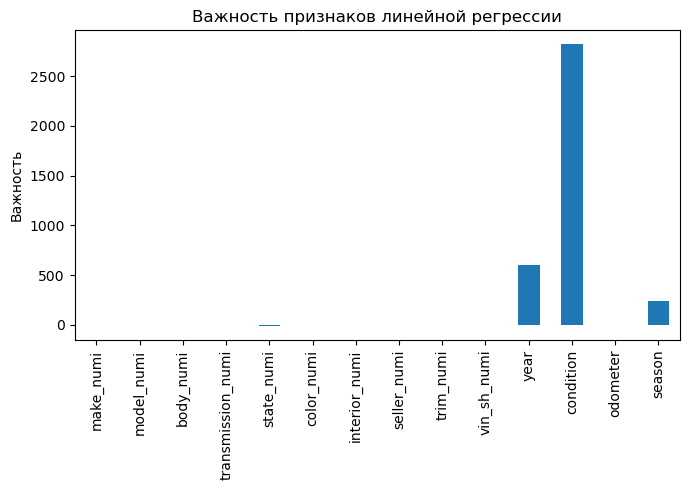

In [64]:
# Построим таблицу признаков линейной регрессии
coefs_reg = pd.DataFrame({
    'params': features_train_s.columns,
    'coef_reg': model_regr_short.coef_
})

# Постриои график признаков
fig, ax = plt.subplots(figsize=(7,5))
coefs_reg.plot.bar(ax=ax)
ax.set_title("Важность признаков линейной регрессии")
ax.set_ylabel('Важность')
ax.set_xticklabels(coefs_reg['params'])
ax.get_legend().remove()
fig.tight_layout()

In [65]:
# Для регрессии важны только три признака. 
# Изменим feature
features_train_s_reg = features_train_s[['year', 'condition', 'season']]
features_test_s_reg = features_test_s[['year', 'condition', 'season']]

print(f'Обучающая выборка признаков для регрессии - {features_train_s_reg.shape}')
print(f'Тестовая выборка признаков для регрессии - {features_test_s_reg.shape}')


Обучающая выборка признаков для регрессии - (330177, 3)
Тестовая выборка признаков для регрессии - (110059, 3)


In [66]:
# Обучим модель линейной регрессии на коротком датасете
model_regr_short_short = LinearRegression()
model_regr_short_short.fit(features_train_s_reg, target_train_s)
answer_regr_short_short = model_regr_short_short.predict(features_test_s_reg)
mape_model_regr_short_short = mean_absolute_percentage_error(target_test_s, answer_regr_short_short)
print(f'MAPE на регрессии на коротком датасете - {mape_model_regr_short_short:.4f}')

MAPE на регрессии на коротком датасете - 0.7004


In [67]:
# Обучим модель линейной регрессии на стандартизирванной выборке
model_regr_skaled = LinearRegression()
model_regr_skaled.fit(features_train_skaled, target_train_s)
answer_regr_skaled = model_regr_skaled.predict(features_test_skaled)
mape_model_regr_skaled = mean_absolute_percentage_error(target_test_s, answer_regr_skaled)
print(f'MAPE на регрессии на стандартизирванной выборке - {mape_model_regr_skaled:.4f}')

MAPE на регрессии на стандартизирванной выборке - 0.6836


### Модель Решающего дерева <a id='3.5'></a>

**Модель Решающего дерева будет применена:**
- На исходной выборке
- На сокращенной выборке
- На стандартизированной  выборке

In [68]:
# Обучим модель Решающего дерева
model_tree_short = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_short.fit(features_train_s, target_train_s)
answer_model_tree_short = model_tree_short.predict(features_test_s)
mape_model_tree_short = mean_absolute_percentage_error(target_test_s, answer_model_tree_short)
print(f'MAPE на дереве с преобразованием категорий суммой - {mape_model_tree_short:.4f}')

MAPE на дереве с преобразованием категорий суммой - 0.3540


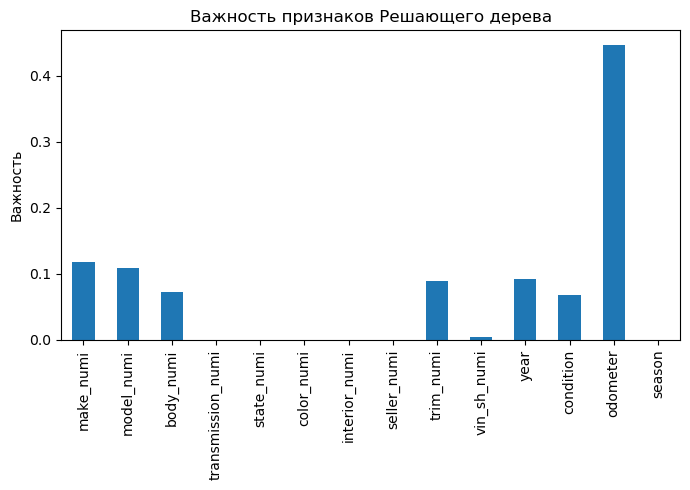

In [69]:
# Построим таблицу признаков Решающего дерева
coefs_tree = pd.DataFrame({
    'params': features_train_s.columns,
    'coef_tree': model_tree_short.feature_importances_
})

# Постриои график признаков
fig, ax = plt.subplots(figsize=(7,5))
coefs_tree.plot.bar(ax=ax)
ax.set_title("Важность признаков Решающего дерева")
ax.set_ylabel('Важность')
ax.set_xticklabels(coefs_tree['params'])
ax.get_legend().remove()
fig.tight_layout()

In [70]:
# Для Решающего дерева важны семь признаков.
# Изменим feature

features_train_s_tr = features_train_s[['make_numi', 'model_numi', 'body_numi', 'trim_numi', 'year', 'condition', 'odometer']]
features_test_s_tr = features_test_s[['make_numi', 'model_numi', 'body_numi', 'trim_numi', 'year', 'condition', 'odometer']]

print(f'Обучающая выборка признаков для Решающего дерева - {features_train_s_tr.shape}')
print(f'Тестовая выборка признаков для Решающего дерева - {features_test_s_tr.shape}')


Обучающая выборка признаков для Решающего дерева - (330177, 7)
Тестовая выборка признаков для Решающего дерева - (110059, 7)


In [71]:
# Обучим модель Решающего дерева на короткот датасете
model_tree_short_short = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_short_short.fit(features_train_s_tr, target_train_s)
answer_model_tree_short_short = model_tree_short_short.predict(features_test_s_tr)
mape_model_tree_short_short = mean_absolute_percentage_error(target_test_s, answer_model_tree_short_short)
print(f'MAPE на дереве на коротком датасете - {mape_model_tree_short_short:.4f}')

MAPE на дереве на коротком датасете - 0.3534


In [72]:
# Обучим модель Решающего дерева на стандартизирванной выборке
model_tree_skaled = DecisionTreeRegressor(max_depth=10, random_state=state)
model_tree_skaled.fit(features_train_skaled, target_train_s)
answer_model_tree_skaled = model_tree_skaled.predict(features_test_skaled)
mape_model_tree_skaled = mean_absolute_percentage_error(target_test_s, answer_model_tree_skaled)
print(f'MAPE на дереве на стандартизирванной выборке - {mape_model_tree_skaled:.4f}')

MAPE на дереве на стандартизирванной выборке - 0.3539


### Методы улучшения качества моделей <a id='3.6'></a>

**Улучшение качества моделей:**
- с использованием кросс-валидации
- с подбором параметра Решающего дерева методом GridSearchCV
- с подбором числа деревьев Случайного леса 
- с использованием Фреймворка LightGBM
- с использованием Фреймворка CatBoost

In [73]:
%%time
# Обучим модель методом линейной регрессии с использованием кросс-валидация (3 части)

model_line_regr_cross_valid = LinearRegression()
scores = cross_val_score(model_line_regr_cross_valid, features_train_s, target_train_s, 
                         cv=3, scoring='neg_mean_absolute_percentage_error')
mape_model_line_regr_cross_valid = -scores.mean()

print(f'На модели линейной регрессии с использованием кросс-валидации средний уровень MAPE = {mape_model_line_regr_cross_valid:.4f}')

На модели линейной регрессии с использованием кросс-валидации средний уровень MAPE = 0.7254
CPU times: total: 2.5 s
Wall time: 2.22 s


In [74]:
%%time
# Подберем лучшие параметры Решающего дерева методом GridSearchCV
clf = DecisionTreeRegressor(random_state=state)
parametrs = {'max_depth': range(10, 26, 5)}

model_tree_regr = GridSearchCV(clf, parametrs, cv=3)
model_tree_regr.fit(features_train_s, target_train_s)
best_depth_tree_regr = model_tree_regr.best_params_.get('max_depth')
print(f'Лучший параметр глубины - {best_depth_tree_regr}')

# Обучим и проверим модель с подобранными параметрами
model_tree = DecisionTreeRegressor(max_depth=best_depth_tree_regr, random_state=state)
model_tree.fit(features_train_s, target_train_s)

answer_model_tree = model_tree.predict(features_test_s)
mape_model_tree = mean_absolute_percentage_error(target_test_s, answer_model_tree)

print(f"Точность модели Решающего дерева методом GridSearchCV по MAPE: {mape_model_tree:.4f}")

Лучший параметр глубины - 20
Точность модели Решающего дерева методом GridSearchCV по MAPE: 0.2313
CPU times: total: 1min 3s
Wall time: 1min 3s


In [75]:
%%time
# Подберем лучшие параметры Решающего дерева меняя число деревьев методом GridSearchCV
clf = RandomForestRegressor(random_state=state, max_depth=best_depth_tree_regr)
parametrs = {'n_estimators': range(10, 21, 10)}

model_forest = GridSearchCV(clf, parametrs, cv=3)
model_forest.fit(features_train_s, target_train_s)
best_est_forest = model_forest.best_params_.get('n_estimators')
print(f'Лучший параметр числа деревьев - {best_est_forest}')

# Обучим и проверим модель с подобранными параметрами
model_forest = RandomForestRegressor(max_depth=best_depth_tree_regr, 
                                     n_estimators=best_est_forest,
                                     random_state=state)
model_forest.fit(features_train_s, target_train_s)

answer_model_forest = model_forest.predict(features_test_s)
mape_model_forest = mean_absolute_percentage_error(target_test_s, answer_model_forest)

print(f"ТТочность модели Случайного леса методом GridSearchCV по MAPE: {mape_model_forest:.4f}")

Лучший параметр числа деревьев - 20
ТТочность модели Случайного леса методом GridSearchCV по MAPE: 0.1968
CPU times: total: 10min 25s
Wall time: 10min 44s


In [76]:
# Создадим модель с использованием Фреймворка LightGBM
lgb_model = lgb.LGBMModel(objective="regression", n_estimators=3000)
lgb_model.fit(features_train_s, target_train_s, eval_set=[(features_test_s, target_test_s),], eval_metric="mape")

answerr_lgb_model = lgb_model.predict(features_test_s)
mape_lgb_model = mean_absolute_percentage_error(target_test_s, answerr_lgb_model)

print(f"Точность модели LightGBM по MAPE: {mape_lgb_model:.4f}")


[1]	valid_0's mape: 1.68317	valid_0's l2: 8.50218e+07
[1000]	valid_0's mape: 0.179118	valid_0's l2: 4.94762e+06
[2000]	valid_0's mape: 0.166674	valid_0's l2: 4.40548e+06
[3000]	valid_0's mape: 0.161821	valid_0's l2: 4.19497e+06
Точность модели LightGBM по MAPE: 0.1618


In [77]:
# Создадим модель с использованием Фреймворка LightGBM на стандартизированных данных
lgb_model_skaled = lgb.LGBMModel(objective="regression", n_estimators=10000)
lgb_model_skaled.fit(features_train_skaled, target_train_s, eval_set=[(features_test_skaled, target_test_s),], eval_metric="mape")

answerr_lgb_model_skaled = lgb_model_skaled.predict(features_test_skaled)
mape_lgb_model_skaled = mean_absolute_percentage_error(target_test_s, answerr_lgb_model_skaled)

print(f"Точность модели LightGBM по MAPE: {mape_lgb_model_skaled:.4f}")

[1]	valid_0's mape: 1.68316	valid_0's l2: 8.50121e+07
[2]	valid_0's mape: 1.56063	valid_0's l2: 7.5826e+07
[3]	valid_0's mape: 1.45254	valid_0's l2: 6.88207e+07
[4]	valid_0's mape: 1.35376	valid_0's l2: 6.2727e+07
[5]	valid_0's mape: 1.2673	valid_0's l2: 5.75861e+07
[6]	valid_0's mape: 1.18247	valid_0's l2: 5.28409e+07
[7]	valid_0's mape: 1.11119	valid_0's l2: 4.90391e+07
[8]	valid_0's mape: 1.0467	valid_0's l2: 4.58568e+07
[9]	valid_0's mape: 0.983817	valid_0's l2: 4.25852e+07
[10]	valid_0's mape: 0.927246	valid_0's l2: 4.01022e+07
[11]	valid_0's mape: 0.879649	valid_0's l2: 3.79714e+07
[12]	valid_0's mape: 0.83536	valid_0's l2: 3.62154e+07
[13]	valid_0's mape: 0.793557	valid_0's l2: 3.4698e+07
[14]	valid_0's mape: 0.760553	valid_0's l2: 3.29546e+07
[15]	valid_0's mape: 0.724797	valid_0's l2: 3.16884e+07
[16]	valid_0's mape: 0.689978	valid_0's l2: 3.02874e+07
[17]	valid_0's mape: 0.661785	valid_0's l2: 2.9163e+07
[18]	valid_0's mape: 0.633027	valid_0's l2: 2.82821e+07
[19]	valid_0's m

[153]	valid_0's mape: 0.240195	valid_0's l2: 8.85896e+06
[154]	valid_0's mape: 0.239708	valid_0's l2: 8.8275e+06
[155]	valid_0's mape: 0.23941	valid_0's l2: 8.81395e+06
[156]	valid_0's mape: 0.239151	valid_0's l2: 8.78298e+06
[157]	valid_0's mape: 0.238601	valid_0's l2: 8.76019e+06
[158]	valid_0's mape: 0.238427	valid_0's l2: 8.74227e+06
[159]	valid_0's mape: 0.238135	valid_0's l2: 8.72847e+06
[160]	valid_0's mape: 0.237994	valid_0's l2: 8.70267e+06
[161]	valid_0's mape: 0.238	valid_0's l2: 8.69291e+06
[162]	valid_0's mape: 0.237462	valid_0's l2: 8.67087e+06
[163]	valid_0's mape: 0.236947	valid_0's l2: 8.62449e+06
[164]	valid_0's mape: 0.236598	valid_0's l2: 8.60686e+06
[165]	valid_0's mape: 0.236613	valid_0's l2: 8.57676e+06
[166]	valid_0's mape: 0.236412	valid_0's l2: 8.55476e+06
[167]	valid_0's mape: 0.236292	valid_0's l2: 8.53445e+06
[168]	valid_0's mape: 0.235573	valid_0's l2: 8.49856e+06
[169]	valid_0's mape: 0.235357	valid_0's l2: 8.47471e+06
[170]	valid_0's mape: 0.234819	valid

[304]	valid_0's mape: 0.211358	valid_0's l2: 6.76598e+06
[305]	valid_0's mape: 0.211299	valid_0's l2: 6.76268e+06
[306]	valid_0's mape: 0.211209	valid_0's l2: 6.75743e+06
[307]	valid_0's mape: 0.211135	valid_0's l2: 6.75324e+06
[308]	valid_0's mape: 0.211111	valid_0's l2: 6.74141e+06
[309]	valid_0's mape: 0.21092	valid_0's l2: 6.73692e+06
[310]	valid_0's mape: 0.210763	valid_0's l2: 6.72812e+06
[311]	valid_0's mape: 0.210571	valid_0's l2: 6.71514e+06
[312]	valid_0's mape: 0.21051	valid_0's l2: 6.70937e+06
[313]	valid_0's mape: 0.210348	valid_0's l2: 6.68287e+06
[314]	valid_0's mape: 0.210229	valid_0's l2: 6.6739e+06
[315]	valid_0's mape: 0.210005	valid_0's l2: 6.66741e+06
[316]	valid_0's mape: 0.209963	valid_0's l2: 6.65888e+06
[317]	valid_0's mape: 0.20991	valid_0's l2: 6.65354e+06
[318]	valid_0's mape: 0.209854	valid_0's l2: 6.64932e+06
[319]	valid_0's mape: 0.209817	valid_0's l2: 6.64429e+06
[320]	valid_0's mape: 0.209712	valid_0's l2: 6.63528e+06
[321]	valid_0's mape: 0.209639	vali

[450]	valid_0's mape: 0.198349	valid_0's l2: 5.97908e+06
[451]	valid_0's mape: 0.198265	valid_0's l2: 5.97494e+06
[452]	valid_0's mape: 0.19819	valid_0's l2: 5.97294e+06
[453]	valid_0's mape: 0.1981	valid_0's l2: 5.97121e+06
[454]	valid_0's mape: 0.197975	valid_0's l2: 5.95905e+06
[455]	valid_0's mape: 0.197921	valid_0's l2: 5.95638e+06
[456]	valid_0's mape: 0.197899	valid_0's l2: 5.95588e+06
[457]	valid_0's mape: 0.197898	valid_0's l2: 5.95456e+06
[458]	valid_0's mape: 0.197881	valid_0's l2: 5.95254e+06
[459]	valid_0's mape: 0.197844	valid_0's l2: 5.95077e+06
[460]	valid_0's mape: 0.197818	valid_0's l2: 5.94943e+06
[461]	valid_0's mape: 0.197771	valid_0's l2: 5.94648e+06
[462]	valid_0's mape: 0.197631	valid_0's l2: 5.93963e+06
[463]	valid_0's mape: 0.197604	valid_0's l2: 5.93053e+06
[464]	valid_0's mape: 0.197553	valid_0's l2: 5.92676e+06
[465]	valid_0's mape: 0.197539	valid_0's l2: 5.92376e+06
[466]	valid_0's mape: 0.197478	valid_0's l2: 5.92208e+06
[467]	valid_0's mape: 0.197291	val

[602]	valid_0's mape: 0.190326	valid_0's l2: 5.49531e+06
[603]	valid_0's mape: 0.190232	valid_0's l2: 5.49221e+06
[604]	valid_0's mape: 0.190228	valid_0's l2: 5.49055e+06
[605]	valid_0's mape: 0.190203	valid_0's l2: 5.48807e+06
[606]	valid_0's mape: 0.190179	valid_0's l2: 5.48918e+06
[607]	valid_0's mape: 0.19017	valid_0's l2: 5.48796e+06
[608]	valid_0's mape: 0.190157	valid_0's l2: 5.48754e+06
[609]	valid_0's mape: 0.190122	valid_0's l2: 5.48513e+06
[610]	valid_0's mape: 0.190065	valid_0's l2: 5.48394e+06
[611]	valid_0's mape: 0.190046	valid_0's l2: 5.48058e+06
[612]	valid_0's mape: 0.189946	valid_0's l2: 5.47938e+06
[613]	valid_0's mape: 0.189932	valid_0's l2: 5.47874e+06
[614]	valid_0's mape: 0.189833	valid_0's l2: 5.47486e+06
[615]	valid_0's mape: 0.1898	valid_0's l2: 5.47369e+06
[616]	valid_0's mape: 0.189771	valid_0's l2: 5.47106e+06
[617]	valid_0's mape: 0.189714	valid_0's l2: 5.46884e+06
[618]	valid_0's mape: 0.189662	valid_0's l2: 5.46847e+06
[619]	valid_0's mape: 0.18968	vali

[751]	valid_0's mape: 0.18442	valid_0's l2: 5.21516e+06
[752]	valid_0's mape: 0.184408	valid_0's l2: 5.21409e+06
[753]	valid_0's mape: 0.18439	valid_0's l2: 5.21294e+06
[754]	valid_0's mape: 0.184398	valid_0's l2: 5.21273e+06
[755]	valid_0's mape: 0.184396	valid_0's l2: 5.21217e+06
[756]	valid_0's mape: 0.184385	valid_0's l2: 5.21124e+06
[757]	valid_0's mape: 0.184379	valid_0's l2: 5.21082e+06
[758]	valid_0's mape: 0.184373	valid_0's l2: 5.21009e+06
[759]	valid_0's mape: 0.184317	valid_0's l2: 5.20977e+06
[760]	valid_0's mape: 0.184309	valid_0's l2: 5.20895e+06
[761]	valid_0's mape: 0.184308	valid_0's l2: 5.20892e+06
[762]	valid_0's mape: 0.184279	valid_0's l2: 5.20484e+06
[763]	valid_0's mape: 0.184262	valid_0's l2: 5.20132e+06
[764]	valid_0's mape: 0.184254	valid_0's l2: 5.19661e+06
[765]	valid_0's mape: 0.184245	valid_0's l2: 5.19563e+06
[766]	valid_0's mape: 0.184198	valid_0's l2: 5.19525e+06
[767]	valid_0's mape: 0.184185	valid_0's l2: 5.19395e+06
[768]	valid_0's mape: 0.184175	va

[899]	valid_0's mape: 0.180756	valid_0's l2: 5.01436e+06
[900]	valid_0's mape: 0.180704	valid_0's l2: 5.01378e+06
[901]	valid_0's mape: 0.180582	valid_0's l2: 5.01018e+06
[902]	valid_0's mape: 0.180572	valid_0's l2: 5.00898e+06
[903]	valid_0's mape: 0.180569	valid_0's l2: 5.00881e+06
[904]	valid_0's mape: 0.18056	valid_0's l2: 5.00842e+06
[905]	valid_0's mape: 0.180555	valid_0's l2: 5.00806e+06
[906]	valid_0's mape: 0.180555	valid_0's l2: 5.00765e+06
[907]	valid_0's mape: 0.180504	valid_0's l2: 5.00564e+06
[908]	valid_0's mape: 0.180497	valid_0's l2: 5.00496e+06
[909]	valid_0's mape: 0.180472	valid_0's l2: 5.00265e+06
[910]	valid_0's mape: 0.180327	valid_0's l2: 5.00138e+06
[911]	valid_0's mape: 0.180301	valid_0's l2: 5.00008e+06
[912]	valid_0's mape: 0.180285	valid_0's l2: 4.99935e+06
[913]	valid_0's mape: 0.180264	valid_0's l2: 4.99813e+06
[914]	valid_0's mape: 0.180233	valid_0's l2: 4.99666e+06
[915]	valid_0's mape: 0.180235	valid_0's l2: 4.99705e+06
[916]	valid_0's mape: 0.180238	v

[1044]	valid_0's mape: 0.177494	valid_0's l2: 4.86841e+06
[1045]	valid_0's mape: 0.177438	valid_0's l2: 4.86617e+06
[1046]	valid_0's mape: 0.177435	valid_0's l2: 4.86604e+06
[1047]	valid_0's mape: 0.177322	valid_0's l2: 4.86459e+06
[1048]	valid_0's mape: 0.177277	valid_0's l2: 4.86413e+06
[1049]	valid_0's mape: 0.17725	valid_0's l2: 4.86383e+06
[1050]	valid_0's mape: 0.177248	valid_0's l2: 4.86356e+06
[1051]	valid_0's mape: 0.17722	valid_0's l2: 4.86303e+06
[1052]	valid_0's mape: 0.177195	valid_0's l2: 4.86243e+06
[1053]	valid_0's mape: 0.177149	valid_0's l2: 4.8614e+06
[1054]	valid_0's mape: 0.177125	valid_0's l2: 4.86079e+06
[1055]	valid_0's mape: 0.177104	valid_0's l2: 4.85917e+06
[1056]	valid_0's mape: 0.17709	valid_0's l2: 4.85797e+06
[1057]	valid_0's mape: 0.177087	valid_0's l2: 4.85766e+06
[1058]	valid_0's mape: 0.177064	valid_0's l2: 4.85714e+06
[1059]	valid_0's mape: 0.177065	valid_0's l2: 4.85655e+06
[1060]	valid_0's mape: 0.177017	valid_0's l2: 4.85562e+06
[1061]	valid_0's m

[1192]	valid_0's mape: 0.174691	valid_0's l2: 4.76103e+06
[1193]	valid_0's mape: 0.174702	valid_0's l2: 4.7595e+06
[1194]	valid_0's mape: 0.174708	valid_0's l2: 4.75884e+06
[1195]	valid_0's mape: 0.174716	valid_0's l2: 4.7582e+06
[1196]	valid_0's mape: 0.174698	valid_0's l2: 4.75757e+06
[1197]	valid_0's mape: 0.1747	valid_0's l2: 4.75763e+06
[1198]	valid_0's mape: 0.174681	valid_0's l2: 4.75714e+06
[1199]	valid_0's mape: 0.174686	valid_0's l2: 4.75665e+06
[1200]	valid_0's mape: 0.174686	valid_0's l2: 4.75712e+06
[1201]	valid_0's mape: 0.174687	valid_0's l2: 4.75691e+06
[1202]	valid_0's mape: 0.174686	valid_0's l2: 4.75686e+06
[1203]	valid_0's mape: 0.174665	valid_0's l2: 4.75556e+06
[1204]	valid_0's mape: 0.174659	valid_0's l2: 4.7551e+06
[1205]	valid_0's mape: 0.174632	valid_0's l2: 4.75327e+06
[1206]	valid_0's mape: 0.174633	valid_0's l2: 4.7534e+06
[1207]	valid_0's mape: 0.174627	valid_0's l2: 4.75334e+06
[1208]	valid_0's mape: 0.174625	valid_0's l2: 4.75323e+06
[1209]	valid_0's map

[1342]	valid_0's mape: 0.17285	valid_0's l2: 4.65797e+06
[1343]	valid_0's mape: 0.172833	valid_0's l2: 4.6573e+06
[1344]	valid_0's mape: 0.1728	valid_0's l2: 4.65703e+06
[1345]	valid_0's mape: 0.172793	valid_0's l2: 4.65546e+06
[1346]	valid_0's mape: 0.17278	valid_0's l2: 4.65502e+06
[1347]	valid_0's mape: 0.172777	valid_0's l2: 4.65513e+06
[1348]	valid_0's mape: 0.172778	valid_0's l2: 4.6549e+06
[1349]	valid_0's mape: 0.172745	valid_0's l2: 4.65337e+06
[1350]	valid_0's mape: 0.172727	valid_0's l2: 4.65302e+06
[1351]	valid_0's mape: 0.172732	valid_0's l2: 4.65287e+06
[1352]	valid_0's mape: 0.172725	valid_0's l2: 4.65278e+06
[1353]	valid_0's mape: 0.172704	valid_0's l2: 4.65199e+06
[1354]	valid_0's mape: 0.172675	valid_0's l2: 4.65125e+06
[1355]	valid_0's mape: 0.172656	valid_0's l2: 4.65115e+06
[1356]	valid_0's mape: 0.172649	valid_0's l2: 4.65103e+06
[1357]	valid_0's mape: 0.172646	valid_0's l2: 4.65034e+06
[1358]	valid_0's mape: 0.172644	valid_0's l2: 4.64988e+06
[1359]	valid_0's map

[1484]	valid_0's mape: 0.171142	valid_0's l2: 4.57935e+06
[1485]	valid_0's mape: 0.17115	valid_0's l2: 4.57937e+06
[1486]	valid_0's mape: 0.171119	valid_0's l2: 4.57872e+06
[1487]	valid_0's mape: 0.171122	valid_0's l2: 4.57863e+06
[1488]	valid_0's mape: 0.171102	valid_0's l2: 4.57788e+06
[1489]	valid_0's mape: 0.171065	valid_0's l2: 4.57651e+06
[1490]	valid_0's mape: 0.171054	valid_0's l2: 4.57553e+06
[1491]	valid_0's mape: 0.171054	valid_0's l2: 4.57554e+06
[1492]	valid_0's mape: 0.171042	valid_0's l2: 4.57505e+06
[1493]	valid_0's mape: 0.171028	valid_0's l2: 4.5746e+06
[1494]	valid_0's mape: 0.171014	valid_0's l2: 4.5742e+06
[1495]	valid_0's mape: 0.170977	valid_0's l2: 4.57384e+06
[1496]	valid_0's mape: 0.170952	valid_0's l2: 4.57299e+06
[1497]	valid_0's mape: 0.17095	valid_0's l2: 4.57292e+06
[1498]	valid_0's mape: 0.170936	valid_0's l2: 4.57268e+06
[1499]	valid_0's mape: 0.170947	valid_0's l2: 4.57258e+06
[1500]	valid_0's mape: 0.170948	valid_0's l2: 4.57218e+06
[1501]	valid_0's m

[1626]	valid_0's mape: 0.169638	valid_0's l2: 4.52563e+06
[1627]	valid_0's mape: 0.169632	valid_0's l2: 4.52471e+06
[1628]	valid_0's mape: 0.169628	valid_0's l2: 4.52458e+06
[1629]	valid_0's mape: 0.169626	valid_0's l2: 4.52426e+06
[1630]	valid_0's mape: 0.169617	valid_0's l2: 4.52374e+06
[1631]	valid_0's mape: 0.169618	valid_0's l2: 4.5237e+06
[1632]	valid_0's mape: 0.169648	valid_0's l2: 4.52361e+06
[1633]	valid_0's mape: 0.169633	valid_0's l2: 4.52324e+06
[1634]	valid_0's mape: 0.169615	valid_0's l2: 4.52272e+06
[1635]	valid_0's mape: 0.169609	valid_0's l2: 4.52259e+06
[1636]	valid_0's mape: 0.169607	valid_0's l2: 4.52229e+06
[1637]	valid_0's mape: 0.169608	valid_0's l2: 4.5223e+06
[1638]	valid_0's mape: 0.169599	valid_0's l2: 4.52229e+06
[1639]	valid_0's mape: 0.169556	valid_0's l2: 4.52234e+06
[1640]	valid_0's mape: 0.169547	valid_0's l2: 4.52226e+06
[1641]	valid_0's mape: 0.169534	valid_0's l2: 4.52172e+06
[1642]	valid_0's mape: 0.169537	valid_0's l2: 4.52134e+06
[1643]	valid_0's

[1776]	valid_0's mape: 0.168368	valid_0's l2: 4.46377e+06
[1777]	valid_0's mape: 0.168357	valid_0's l2: 4.46242e+06
[1778]	valid_0's mape: 0.168361	valid_0's l2: 4.46251e+06
[1779]	valid_0's mape: 0.168363	valid_0's l2: 4.46208e+06
[1780]	valid_0's mape: 0.168356	valid_0's l2: 4.46178e+06
[1781]	valid_0's mape: 0.16835	valid_0's l2: 4.46159e+06
[1782]	valid_0's mape: 0.168366	valid_0's l2: 4.4602e+06
[1783]	valid_0's mape: 0.168364	valid_0's l2: 4.4602e+06
[1784]	valid_0's mape: 0.168347	valid_0's l2: 4.45992e+06
[1785]	valid_0's mape: 0.168337	valid_0's l2: 4.45931e+06
[1786]	valid_0's mape: 0.168327	valid_0's l2: 4.45908e+06
[1787]	valid_0's mape: 0.16831	valid_0's l2: 4.45875e+06
[1788]	valid_0's mape: 0.168298	valid_0's l2: 4.45819e+06
[1789]	valid_0's mape: 0.168295	valid_0's l2: 4.45747e+06
[1790]	valid_0's mape: 0.168258	valid_0's l2: 4.45668e+06
[1791]	valid_0's mape: 0.168231	valid_0's l2: 4.45624e+06
[1792]	valid_0's mape: 0.168231	valid_0's l2: 4.4559e+06
[1793]	valid_0's ma

[1927]	valid_0's mape: 0.167272	valid_0's l2: 4.41524e+06
[1928]	valid_0's mape: 0.167257	valid_0's l2: 4.41442e+06
[1929]	valid_0's mape: 0.167261	valid_0's l2: 4.41429e+06
[1930]	valid_0's mape: 0.167262	valid_0's l2: 4.41413e+06
[1931]	valid_0's mape: 0.167245	valid_0's l2: 4.41339e+06
[1932]	valid_0's mape: 0.167235	valid_0's l2: 4.41268e+06
[1933]	valid_0's mape: 0.167228	valid_0's l2: 4.41244e+06
[1934]	valid_0's mape: 0.167227	valid_0's l2: 4.41221e+06
[1935]	valid_0's mape: 0.167226	valid_0's l2: 4.41207e+06
[1936]	valid_0's mape: 0.167225	valid_0's l2: 4.41216e+06
[1937]	valid_0's mape: 0.167223	valid_0's l2: 4.41208e+06
[1938]	valid_0's mape: 0.167217	valid_0's l2: 4.41167e+06
[1939]	valid_0's mape: 0.167216	valid_0's l2: 4.41139e+06
[1940]	valid_0's mape: 0.167222	valid_0's l2: 4.41115e+06
[1941]	valid_0's mape: 0.167222	valid_0's l2: 4.41108e+06
[1942]	valid_0's mape: 0.167215	valid_0's l2: 4.41088e+06
[1943]	valid_0's mape: 0.167193	valid_0's l2: 4.41022e+06
[1944]	valid_0

[2071]	valid_0's mape: 0.166549	valid_0's l2: 4.37121e+06
[2072]	valid_0's mape: 0.166546	valid_0's l2: 4.37099e+06
[2073]	valid_0's mape: 0.166551	valid_0's l2: 4.37101e+06
[2074]	valid_0's mape: 0.166551	valid_0's l2: 4.37084e+06
[2075]	valid_0's mape: 0.166548	valid_0's l2: 4.3707e+06
[2076]	valid_0's mape: 0.16655	valid_0's l2: 4.37073e+06
[2077]	valid_0's mape: 0.166545	valid_0's l2: 4.3705e+06
[2078]	valid_0's mape: 0.166543	valid_0's l2: 4.37048e+06
[2079]	valid_0's mape: 0.166546	valid_0's l2: 4.36991e+06
[2080]	valid_0's mape: 0.166553	valid_0's l2: 4.36995e+06
[2081]	valid_0's mape: 0.166556	valid_0's l2: 4.3701e+06
[2082]	valid_0's mape: 0.166552	valid_0's l2: 4.37002e+06
[2083]	valid_0's mape: 0.166551	valid_0's l2: 4.36977e+06
[2084]	valid_0's mape: 0.166542	valid_0's l2: 4.3696e+06
[2085]	valid_0's mape: 0.166553	valid_0's l2: 4.36845e+06
[2086]	valid_0's mape: 0.166549	valid_0's l2: 4.36837e+06
[2087]	valid_0's mape: 0.166543	valid_0's l2: 4.36835e+06
[2088]	valid_0's ma

[2222]	valid_0's mape: 0.16563	valid_0's l2: 4.33734e+06
[2223]	valid_0's mape: 0.165623	valid_0's l2: 4.33673e+06
[2224]	valid_0's mape: 0.16561	valid_0's l2: 4.33549e+06
[2225]	valid_0's mape: 0.16562	valid_0's l2: 4.33258e+06
[2226]	valid_0's mape: 0.165621	valid_0's l2: 4.33223e+06
[2227]	valid_0's mape: 0.165612	valid_0's l2: 4.33069e+06
[2228]	valid_0's mape: 0.165612	valid_0's l2: 4.33058e+06
[2229]	valid_0's mape: 0.165609	valid_0's l2: 4.33044e+06
[2230]	valid_0's mape: 0.165601	valid_0's l2: 4.33022e+06
[2231]	valid_0's mape: 0.165603	valid_0's l2: 4.33005e+06
[2232]	valid_0's mape: 0.165598	valid_0's l2: 4.3298e+06
[2233]	valid_0's mape: 0.165581	valid_0's l2: 4.32987e+06
[2234]	valid_0's mape: 0.16558	valid_0's l2: 4.32971e+06
[2235]	valid_0's mape: 0.165581	valid_0's l2: 4.32964e+06
[2236]	valid_0's mape: 0.165579	valid_0's l2: 4.32945e+06
[2237]	valid_0's mape: 0.165581	valid_0's l2: 4.32936e+06
[2238]	valid_0's mape: 0.16558	valid_0's l2: 4.32944e+06
[2239]	valid_0's map

[2368]	valid_0's mape: 0.164699	valid_0's l2: 4.29679e+06
[2369]	valid_0's mape: 0.164677	valid_0's l2: 4.29624e+06
[2370]	valid_0's mape: 0.164678	valid_0's l2: 4.29632e+06
[2371]	valid_0's mape: 0.164663	valid_0's l2: 4.29613e+06
[2372]	valid_0's mape: 0.164664	valid_0's l2: 4.29614e+06
[2373]	valid_0's mape: 0.164665	valid_0's l2: 4.29618e+06
[2374]	valid_0's mape: 0.164662	valid_0's l2: 4.29642e+06
[2375]	valid_0's mape: 0.164657	valid_0's l2: 4.29657e+06
[2376]	valid_0's mape: 0.16466	valid_0's l2: 4.29607e+06
[2377]	valid_0's mape: 0.16464	valid_0's l2: 4.29568e+06
[2378]	valid_0's mape: 0.164637	valid_0's l2: 4.2954e+06
[2379]	valid_0's mape: 0.164631	valid_0's l2: 4.29499e+06
[2380]	valid_0's mape: 0.16463	valid_0's l2: 4.29468e+06
[2381]	valid_0's mape: 0.164617	valid_0's l2: 4.29456e+06
[2382]	valid_0's mape: 0.164619	valid_0's l2: 4.29448e+06
[2383]	valid_0's mape: 0.164604	valid_0's l2: 4.29429e+06
[2384]	valid_0's mape: 0.164604	valid_0's l2: 4.29422e+06
[2385]	valid_0's m

[2511]	valid_0's mape: 0.16398	valid_0's l2: 4.26898e+06
[2512]	valid_0's mape: 0.163964	valid_0's l2: 4.26861e+06
[2513]	valid_0's mape: 0.163941	valid_0's l2: 4.26845e+06
[2514]	valid_0's mape: 0.163935	valid_0's l2: 4.26803e+06
[2515]	valid_0's mape: 0.163934	valid_0's l2: 4.26789e+06
[2516]	valid_0's mape: 0.16393	valid_0's l2: 4.26785e+06
[2517]	valid_0's mape: 0.163934	valid_0's l2: 4.26768e+06
[2518]	valid_0's mape: 0.163937	valid_0's l2: 4.26763e+06
[2519]	valid_0's mape: 0.163936	valid_0's l2: 4.2669e+06
[2520]	valid_0's mape: 0.163934	valid_0's l2: 4.2669e+06
[2521]	valid_0's mape: 0.163939	valid_0's l2: 4.26697e+06
[2522]	valid_0's mape: 0.163943	valid_0's l2: 4.26673e+06
[2523]	valid_0's mape: 0.163936	valid_0's l2: 4.26662e+06
[2524]	valid_0's mape: 0.163936	valid_0's l2: 4.26676e+06
[2525]	valid_0's mape: 0.16393	valid_0's l2: 4.26648e+06
[2526]	valid_0's mape: 0.163925	valid_0's l2: 4.26658e+06
[2527]	valid_0's mape: 0.163918	valid_0's l2: 4.26642e+06
[2528]	valid_0's ma

[2656]	valid_0's mape: 0.163503	valid_0's l2: 4.24109e+06
[2657]	valid_0's mape: 0.163505	valid_0's l2: 4.24103e+06
[2658]	valid_0's mape: 0.163489	valid_0's l2: 4.24091e+06
[2659]	valid_0's mape: 0.163485	valid_0's l2: 4.24064e+06
[2660]	valid_0's mape: 0.163496	valid_0's l2: 4.24057e+06
[2661]	valid_0's mape: 0.163497	valid_0's l2: 4.24054e+06
[2662]	valid_0's mape: 0.163488	valid_0's l2: 4.24078e+06
[2663]	valid_0's mape: 0.163482	valid_0's l2: 4.24065e+06
[2664]	valid_0's mape: 0.163482	valid_0's l2: 4.24026e+06
[2665]	valid_0's mape: 0.163475	valid_0's l2: 4.24018e+06
[2666]	valid_0's mape: 0.163489	valid_0's l2: 4.24002e+06
[2667]	valid_0's mape: 0.163473	valid_0's l2: 4.23996e+06
[2668]	valid_0's mape: 0.163457	valid_0's l2: 4.23938e+06
[2669]	valid_0's mape: 0.16344	valid_0's l2: 4.23907e+06
[2670]	valid_0's mape: 0.163437	valid_0's l2: 4.23897e+06
[2671]	valid_0's mape: 0.16344	valid_0's l2: 4.23899e+06
[2672]	valid_0's mape: 0.163438	valid_0's l2: 4.23869e+06
[2673]	valid_0's

[2801]	valid_0's mape: 0.163002	valid_0's l2: 4.22847e+06
[2802]	valid_0's mape: 0.163	valid_0's l2: 4.22839e+06
[2803]	valid_0's mape: 0.162994	valid_0's l2: 4.22821e+06
[2804]	valid_0's mape: 0.162976	valid_0's l2: 4.22786e+06
[2805]	valid_0's mape: 0.162969	valid_0's l2: 4.22794e+06
[2806]	valid_0's mape: 0.162971	valid_0's l2: 4.22775e+06
[2807]	valid_0's mape: 0.162973	valid_0's l2: 4.22769e+06
[2808]	valid_0's mape: 0.162959	valid_0's l2: 4.22748e+06
[2809]	valid_0's mape: 0.162954	valid_0's l2: 4.22732e+06
[2810]	valid_0's mape: 0.162948	valid_0's l2: 4.22725e+06
[2811]	valid_0's mape: 0.162955	valid_0's l2: 4.2273e+06
[2812]	valid_0's mape: 0.162956	valid_0's l2: 4.22739e+06
[2813]	valid_0's mape: 0.162958	valid_0's l2: 4.22725e+06
[2814]	valid_0's mape: 0.162964	valid_0's l2: 4.22725e+06
[2815]	valid_0's mape: 0.162967	valid_0's l2: 4.2272e+06
[2816]	valid_0's mape: 0.162968	valid_0's l2: 4.227e+06
[2817]	valid_0's mape: 0.162965	valid_0's l2: 4.22692e+06
[2818]	valid_0's mape

[2951]	valid_0's mape: 0.162368	valid_0's l2: 4.20454e+06
[2952]	valid_0's mape: 0.162374	valid_0's l2: 4.20449e+06
[2953]	valid_0's mape: 0.162371	valid_0's l2: 4.20429e+06
[2954]	valid_0's mape: 0.162349	valid_0's l2: 4.20402e+06
[2955]	valid_0's mape: 0.162348	valid_0's l2: 4.20409e+06
[2956]	valid_0's mape: 0.162343	valid_0's l2: 4.20384e+06
[2957]	valid_0's mape: 0.162342	valid_0's l2: 4.20382e+06
[2958]	valid_0's mape: 0.162343	valid_0's l2: 4.20387e+06
[2959]	valid_0's mape: 0.162348	valid_0's l2: 4.20387e+06
[2960]	valid_0's mape: 0.16234	valid_0's l2: 4.20341e+06
[2961]	valid_0's mape: 0.162338	valid_0's l2: 4.20332e+06
[2962]	valid_0's mape: 0.16234	valid_0's l2: 4.20341e+06
[2963]	valid_0's mape: 0.16234	valid_0's l2: 4.20329e+06
[2964]	valid_0's mape: 0.162331	valid_0's l2: 4.20316e+06
[2965]	valid_0's mape: 0.162335	valid_0's l2: 4.20302e+06
[2966]	valid_0's mape: 0.162336	valid_0's l2: 4.20303e+06
[2967]	valid_0's mape: 0.162337	valid_0's l2: 4.20298e+06
[2968]	valid_0's 

[3093]	valid_0's mape: 0.161963	valid_0's l2: 4.1854e+06
[3094]	valid_0's mape: 0.161942	valid_0's l2: 4.18503e+06
[3095]	valid_0's mape: 0.161938	valid_0's l2: 4.18487e+06
[3096]	valid_0's mape: 0.161935	valid_0's l2: 4.18416e+06
[3097]	valid_0's mape: 0.161931	valid_0's l2: 4.18384e+06
[3098]	valid_0's mape: 0.161926	valid_0's l2: 4.18372e+06
[3099]	valid_0's mape: 0.161925	valid_0's l2: 4.18362e+06
[3100]	valid_0's mape: 0.161931	valid_0's l2: 4.18331e+06
[3101]	valid_0's mape: 0.161928	valid_0's l2: 4.18326e+06
[3102]	valid_0's mape: 0.161919	valid_0's l2: 4.18317e+06
[3103]	valid_0's mape: 0.161909	valid_0's l2: 4.18311e+06
[3104]	valid_0's mape: 0.161905	valid_0's l2: 4.18319e+06
[3105]	valid_0's mape: 0.161905	valid_0's l2: 4.18242e+06
[3106]	valid_0's mape: 0.16188	valid_0's l2: 4.18193e+06
[3107]	valid_0's mape: 0.161882	valid_0's l2: 4.18179e+06
[3108]	valid_0's mape: 0.161863	valid_0's l2: 4.18169e+06
[3109]	valid_0's mape: 0.161844	valid_0's l2: 4.18141e+06
[3110]	valid_0's

[3239]	valid_0's mape: 0.161305	valid_0's l2: 4.16342e+06
[3240]	valid_0's mape: 0.161306	valid_0's l2: 4.16342e+06
[3241]	valid_0's mape: 0.161309	valid_0's l2: 4.16323e+06
[3242]	valid_0's mape: 0.161294	valid_0's l2: 4.16323e+06
[3243]	valid_0's mape: 0.161295	valid_0's l2: 4.16326e+06
[3244]	valid_0's mape: 0.161293	valid_0's l2: 4.16306e+06
[3245]	valid_0's mape: 0.16129	valid_0's l2: 4.16314e+06
[3246]	valid_0's mape: 0.161291	valid_0's l2: 4.16296e+06
[3247]	valid_0's mape: 0.161292	valid_0's l2: 4.16305e+06
[3248]	valid_0's mape: 0.161288	valid_0's l2: 4.16307e+06
[3249]	valid_0's mape: 0.161299	valid_0's l2: 4.16307e+06
[3250]	valid_0's mape: 0.1613	valid_0's l2: 4.16313e+06
[3251]	valid_0's mape: 0.161296	valid_0's l2: 4.16306e+06
[3252]	valid_0's mape: 0.161297	valid_0's l2: 4.16302e+06
[3253]	valid_0's mape: 0.161294	valid_0's l2: 4.16292e+06
[3254]	valid_0's mape: 0.161293	valid_0's l2: 4.1629e+06
[3255]	valid_0's mape: 0.161292	valid_0's l2: 4.16285e+06
[3256]	valid_0's m

[3386]	valid_0's mape: 0.160919	valid_0's l2: 4.14863e+06
[3387]	valid_0's mape: 0.160912	valid_0's l2: 4.1484e+06
[3388]	valid_0's mape: 0.160905	valid_0's l2: 4.14817e+06
[3389]	valid_0's mape: 0.160902	valid_0's l2: 4.14796e+06
[3390]	valid_0's mape: 0.160901	valid_0's l2: 4.14796e+06
[3391]	valid_0's mape: 0.160898	valid_0's l2: 4.14743e+06
[3392]	valid_0's mape: 0.160899	valid_0's l2: 4.14741e+06
[3393]	valid_0's mape: 0.160905	valid_0's l2: 4.14684e+06
[3394]	valid_0's mape: 0.160898	valid_0's l2: 4.14682e+06
[3395]	valid_0's mape: 0.160901	valid_0's l2: 4.14683e+06
[3396]	valid_0's mape: 0.160903	valid_0's l2: 4.14676e+06
[3397]	valid_0's mape: 0.160904	valid_0's l2: 4.14662e+06
[3398]	valid_0's mape: 0.160901	valid_0's l2: 4.14642e+06
[3399]	valid_0's mape: 0.160893	valid_0's l2: 4.14639e+06
[3400]	valid_0's mape: 0.160888	valid_0's l2: 4.1464e+06
[3401]	valid_0's mape: 0.160894	valid_0's l2: 4.1464e+06
[3402]	valid_0's mape: 0.1609	valid_0's l2: 4.14627e+06
[3403]	valid_0's ma

[3529]	valid_0's mape: 0.160454	valid_0's l2: 4.13531e+06
[3530]	valid_0's mape: 0.160447	valid_0's l2: 4.13489e+06
[3531]	valid_0's mape: 0.160455	valid_0's l2: 4.13501e+06
[3532]	valid_0's mape: 0.160452	valid_0's l2: 4.1347e+06
[3533]	valid_0's mape: 0.160452	valid_0's l2: 4.13483e+06
[3534]	valid_0's mape: 0.160449	valid_0's l2: 4.13481e+06
[3535]	valid_0's mape: 0.160449	valid_0's l2: 4.1348e+06
[3536]	valid_0's mape: 0.160447	valid_0's l2: 4.13431e+06
[3537]	valid_0's mape: 0.160442	valid_0's l2: 4.13434e+06
[3538]	valid_0's mape: 0.160449	valid_0's l2: 4.13383e+06
[3539]	valid_0's mape: 0.16045	valid_0's l2: 4.1338e+06
[3540]	valid_0's mape: 0.160452	valid_0's l2: 4.13377e+06
[3541]	valid_0's mape: 0.16044	valid_0's l2: 4.1334e+06
[3542]	valid_0's mape: 0.160447	valid_0's l2: 4.13335e+06
[3543]	valid_0's mape: 0.160447	valid_0's l2: 4.13321e+06
[3544]	valid_0's mape: 0.160449	valid_0's l2: 4.13362e+06
[3545]	valid_0's mape: 0.160455	valid_0's l2: 4.13372e+06
[3546]	valid_0's map

[3673]	valid_0's mape: 0.160105	valid_0's l2: 4.12077e+06
[3674]	valid_0's mape: 0.160103	valid_0's l2: 4.12069e+06
[3675]	valid_0's mape: 0.160087	valid_0's l2: 4.12051e+06
[3676]	valid_0's mape: 0.16009	valid_0's l2: 4.12051e+06
[3677]	valid_0's mape: 0.16009	valid_0's l2: 4.12048e+06
[3678]	valid_0's mape: 0.160087	valid_0's l2: 4.12039e+06
[3679]	valid_0's mape: 0.160081	valid_0's l2: 4.12036e+06
[3680]	valid_0's mape: 0.160079	valid_0's l2: 4.12026e+06
[3681]	valid_0's mape: 0.16008	valid_0's l2: 4.12017e+06
[3682]	valid_0's mape: 0.160084	valid_0's l2: 4.12004e+06
[3683]	valid_0's mape: 0.160083	valid_0's l2: 4.11998e+06
[3684]	valid_0's mape: 0.160086	valid_0's l2: 4.11982e+06
[3685]	valid_0's mape: 0.16008	valid_0's l2: 4.1197e+06
[3686]	valid_0's mape: 0.160087	valid_0's l2: 4.11968e+06
[3687]	valid_0's mape: 0.160088	valid_0's l2: 4.11956e+06
[3688]	valid_0's mape: 0.160088	valid_0's l2: 4.11927e+06
[3689]	valid_0's mape: 0.160085	valid_0's l2: 4.11917e+06
[3690]	valid_0's ma

[3819]	valid_0's mape: 0.15979	valid_0's l2: 4.1067e+06
[3820]	valid_0's mape: 0.159789	valid_0's l2: 4.10663e+06
[3821]	valid_0's mape: 0.159778	valid_0's l2: 4.10651e+06
[3822]	valid_0's mape: 0.159779	valid_0's l2: 4.10654e+06
[3823]	valid_0's mape: 0.159768	valid_0's l2: 4.10635e+06
[3824]	valid_0's mape: 0.159767	valid_0's l2: 4.10628e+06
[3825]	valid_0's mape: 0.159747	valid_0's l2: 4.10611e+06
[3826]	valid_0's mape: 0.159747	valid_0's l2: 4.1061e+06
[3827]	valid_0's mape: 0.159747	valid_0's l2: 4.10606e+06
[3828]	valid_0's mape: 0.159749	valid_0's l2: 4.10608e+06
[3829]	valid_0's mape: 0.159748	valid_0's l2: 4.10596e+06
[3830]	valid_0's mape: 0.159749	valid_0's l2: 4.10592e+06
[3831]	valid_0's mape: 0.159744	valid_0's l2: 4.10586e+06
[3832]	valid_0's mape: 0.159745	valid_0's l2: 4.10585e+06
[3833]	valid_0's mape: 0.159743	valid_0's l2: 4.10568e+06
[3834]	valid_0's mape: 0.159739	valid_0's l2: 4.10567e+06
[3835]	valid_0's mape: 0.159738	valid_0's l2: 4.1056e+06
[3836]	valid_0's m

[3962]	valid_0's mape: 0.159471	valid_0's l2: 4.0941e+06
[3963]	valid_0's mape: 0.159474	valid_0's l2: 4.09408e+06
[3964]	valid_0's mape: 0.159472	valid_0's l2: 4.09406e+06
[3965]	valid_0's mape: 0.159473	valid_0's l2: 4.09409e+06
[3966]	valid_0's mape: 0.159474	valid_0's l2: 4.09408e+06
[3967]	valid_0's mape: 0.159471	valid_0's l2: 4.09405e+06
[3968]	valid_0's mape: 0.159471	valid_0's l2: 4.09404e+06
[3969]	valid_0's mape: 0.159467	valid_0's l2: 4.09335e+06
[3970]	valid_0's mape: 0.159469	valid_0's l2: 4.09328e+06
[3971]	valid_0's mape: 0.159464	valid_0's l2: 4.09323e+06
[3972]	valid_0's mape: 0.159465	valid_0's l2: 4.09319e+06
[3973]	valid_0's mape: 0.159467	valid_0's l2: 4.09329e+06
[3974]	valid_0's mape: 0.159467	valid_0's l2: 4.09327e+06
[3975]	valid_0's mape: 0.159465	valid_0's l2: 4.09329e+06
[3976]	valid_0's mape: 0.159465	valid_0's l2: 4.09327e+06
[3977]	valid_0's mape: 0.159459	valid_0's l2: 4.09332e+06
[3978]	valid_0's mape: 0.159455	valid_0's l2: 4.09331e+06
[3979]	valid_0'

[4109]	valid_0's mape: 0.159264	valid_0's l2: 4.08492e+06
[4110]	valid_0's mape: 0.159257	valid_0's l2: 4.0845e+06
[4111]	valid_0's mape: 0.159259	valid_0's l2: 4.0845e+06
[4112]	valid_0's mape: 0.159265	valid_0's l2: 4.08445e+06
[4113]	valid_0's mape: 0.159264	valid_0's l2: 4.08444e+06
[4114]	valid_0's mape: 0.159265	valid_0's l2: 4.08443e+06
[4115]	valid_0's mape: 0.159271	valid_0's l2: 4.08443e+06
[4116]	valid_0's mape: 0.159271	valid_0's l2: 4.0844e+06
[4117]	valid_0's mape: 0.159272	valid_0's l2: 4.08445e+06
[4118]	valid_0's mape: 0.159269	valid_0's l2: 4.08449e+06
[4119]	valid_0's mape: 0.159268	valid_0's l2: 4.08444e+06
[4120]	valid_0's mape: 0.159258	valid_0's l2: 4.08443e+06
[4121]	valid_0's mape: 0.159259	valid_0's l2: 4.08452e+06
[4122]	valid_0's mape: 0.159259	valid_0's l2: 4.08455e+06
[4123]	valid_0's mape: 0.159262	valid_0's l2: 4.08452e+06
[4124]	valid_0's mape: 0.159259	valid_0's l2: 4.08453e+06
[4125]	valid_0's mape: 0.159258	valid_0's l2: 4.08462e+06
[4126]	valid_0's 

[4253]	valid_0's mape: 0.159096	valid_0's l2: 4.07933e+06
[4254]	valid_0's mape: 0.159105	valid_0's l2: 4.07934e+06
[4255]	valid_0's mape: 0.159107	valid_0's l2: 4.07933e+06
[4256]	valid_0's mape: 0.159108	valid_0's l2: 4.07929e+06
[4257]	valid_0's mape: 0.159098	valid_0's l2: 4.07927e+06
[4258]	valid_0's mape: 0.159071	valid_0's l2: 4.07924e+06
[4259]	valid_0's mape: 0.15907	valid_0's l2: 4.07914e+06
[4260]	valid_0's mape: 0.159068	valid_0's l2: 4.07908e+06
[4261]	valid_0's mape: 0.159051	valid_0's l2: 4.07859e+06
[4262]	valid_0's mape: 0.159051	valid_0's l2: 4.07854e+06
[4263]	valid_0's mape: 0.159045	valid_0's l2: 4.07846e+06
[4264]	valid_0's mape: 0.159043	valid_0's l2: 4.07852e+06
[4265]	valid_0's mape: 0.159047	valid_0's l2: 4.07851e+06
[4266]	valid_0's mape: 0.159046	valid_0's l2: 4.07844e+06
[4267]	valid_0's mape: 0.159048	valid_0's l2: 4.07845e+06
[4268]	valid_0's mape: 0.159044	valid_0's l2: 4.07837e+06
[4269]	valid_0's mape: 0.15904	valid_0's l2: 4.07817e+06
[4270]	valid_0's

[4400]	valid_0's mape: 0.158743	valid_0's l2: 4.06796e+06
[4401]	valid_0's mape: 0.158742	valid_0's l2: 4.06786e+06
[4402]	valid_0's mape: 0.158746	valid_0's l2: 4.06785e+06
[4403]	valid_0's mape: 0.158746	valid_0's l2: 4.06784e+06
[4404]	valid_0's mape: 0.158744	valid_0's l2: 4.06727e+06
[4405]	valid_0's mape: 0.158748	valid_0's l2: 4.06706e+06
[4406]	valid_0's mape: 0.158747	valid_0's l2: 4.06706e+06
[4407]	valid_0's mape: 0.158748	valid_0's l2: 4.06712e+06
[4408]	valid_0's mape: 0.158745	valid_0's l2: 4.06722e+06
[4409]	valid_0's mape: 0.158747	valid_0's l2: 4.06722e+06
[4410]	valid_0's mape: 0.158742	valid_0's l2: 4.06722e+06
[4411]	valid_0's mape: 0.158738	valid_0's l2: 4.06721e+06
[4412]	valid_0's mape: 0.158749	valid_0's l2: 4.06722e+06
[4413]	valid_0's mape: 0.15875	valid_0's l2: 4.06726e+06
[4414]	valid_0's mape: 0.158746	valid_0's l2: 4.06729e+06
[4415]	valid_0's mape: 0.158758	valid_0's l2: 4.06711e+06
[4416]	valid_0's mape: 0.158756	valid_0's l2: 4.0669e+06
[4417]	valid_0's

[4545]	valid_0's mape: 0.158521	valid_0's l2: 4.05902e+06
[4546]	valid_0's mape: 0.158521	valid_0's l2: 4.059e+06
[4547]	valid_0's mape: 0.158524	valid_0's l2: 4.05904e+06
[4548]	valid_0's mape: 0.158521	valid_0's l2: 4.05898e+06
[4549]	valid_0's mape: 0.158522	valid_0's l2: 4.05896e+06
[4550]	valid_0's mape: 0.158523	valid_0's l2: 4.05892e+06
[4551]	valid_0's mape: 0.158524	valid_0's l2: 4.05893e+06
[4552]	valid_0's mape: 0.158522	valid_0's l2: 4.05924e+06
[4553]	valid_0's mape: 0.158521	valid_0's l2: 4.05927e+06
[4554]	valid_0's mape: 0.158526	valid_0's l2: 4.05931e+06
[4555]	valid_0's mape: 0.158519	valid_0's l2: 4.05918e+06
[4556]	valid_0's mape: 0.158522	valid_0's l2: 4.0591e+06
[4557]	valid_0's mape: 0.158522	valid_0's l2: 4.05907e+06
[4558]	valid_0's mape: 0.158523	valid_0's l2: 4.05908e+06
[4559]	valid_0's mape: 0.158526	valid_0's l2: 4.05899e+06
[4560]	valid_0's mape: 0.158522	valid_0's l2: 4.05888e+06
[4561]	valid_0's mape: 0.158527	valid_0's l2: 4.0588e+06
[4562]	valid_0's m

[4691]	valid_0's mape: 0.158316	valid_0's l2: 4.04688e+06
[4692]	valid_0's mape: 0.158315	valid_0's l2: 4.04683e+06
[4693]	valid_0's mape: 0.158313	valid_0's l2: 4.04683e+06
[4694]	valid_0's mape: 0.158313	valid_0's l2: 4.04681e+06
[4695]	valid_0's mape: 0.158315	valid_0's l2: 4.04683e+06
[4696]	valid_0's mape: 0.158321	valid_0's l2: 4.04678e+06
[4697]	valid_0's mape: 0.158306	valid_0's l2: 4.04661e+06
[4698]	valid_0's mape: 0.158306	valid_0's l2: 4.04665e+06
[4699]	valid_0's mape: 0.158302	valid_0's l2: 4.04655e+06
[4700]	valid_0's mape: 0.1583	valid_0's l2: 4.04662e+06
[4701]	valid_0's mape: 0.158295	valid_0's l2: 4.04644e+06
[4702]	valid_0's mape: 0.158302	valid_0's l2: 4.04633e+06
[4703]	valid_0's mape: 0.158303	valid_0's l2: 4.04633e+06
[4704]	valid_0's mape: 0.158302	valid_0's l2: 4.04633e+06
[4705]	valid_0's mape: 0.158302	valid_0's l2: 4.0463e+06
[4706]	valid_0's mape: 0.158303	valid_0's l2: 4.0463e+06
[4707]	valid_0's mape: 0.158304	valid_0's l2: 4.04628e+06
[4708]	valid_0's m

[4839]	valid_0's mape: 0.158187	valid_0's l2: 4.03846e+06
[4840]	valid_0's mape: 0.158185	valid_0's l2: 4.03858e+06
[4841]	valid_0's mape: 0.158178	valid_0's l2: 4.03846e+06
[4842]	valid_0's mape: 0.158175	valid_0's l2: 4.03839e+06
[4843]	valid_0's mape: 0.158148	valid_0's l2: 4.03816e+06
[4844]	valid_0's mape: 0.158146	valid_0's l2: 4.03817e+06
[4845]	valid_0's mape: 0.158138	valid_0's l2: 4.03805e+06
[4846]	valid_0's mape: 0.158136	valid_0's l2: 4.03805e+06
[4847]	valid_0's mape: 0.15814	valid_0's l2: 4.03811e+06
[4848]	valid_0's mape: 0.15814	valid_0's l2: 4.03811e+06
[4849]	valid_0's mape: 0.158139	valid_0's l2: 4.03804e+06
[4850]	valid_0's mape: 0.158138	valid_0's l2: 4.03801e+06
[4851]	valid_0's mape: 0.158137	valid_0's l2: 4.03818e+06
[4852]	valid_0's mape: 0.158145	valid_0's l2: 4.03811e+06
[4853]	valid_0's mape: 0.15814	valid_0's l2: 4.038e+06
[4854]	valid_0's mape: 0.158142	valid_0's l2: 4.03803e+06
[4855]	valid_0's mape: 0.158137	valid_0's l2: 4.03806e+06
[4856]	valid_0's ma

[4992]	valid_0's mape: 0.157999	valid_0's l2: 4.03171e+06
[4993]	valid_0's mape: 0.158011	valid_0's l2: 4.0317e+06
[4994]	valid_0's mape: 0.15801	valid_0's l2: 4.03166e+06
[4995]	valid_0's mape: 0.158011	valid_0's l2: 4.0317e+06
[4996]	valid_0's mape: 0.158007	valid_0's l2: 4.03146e+06
[4997]	valid_0's mape: 0.158004	valid_0's l2: 4.03099e+06
[4998]	valid_0's mape: 0.158005	valid_0's l2: 4.03097e+06
[4999]	valid_0's mape: 0.158004	valid_0's l2: 4.03104e+06
[5000]	valid_0's mape: 0.158003	valid_0's l2: 4.03107e+06
[5001]	valid_0's mape: 0.15801	valid_0's l2: 4.031e+06
[5002]	valid_0's mape: 0.158006	valid_0's l2: 4.03099e+06
[5003]	valid_0's mape: 0.158009	valid_0's l2: 4.03099e+06
[5004]	valid_0's mape: 0.158011	valid_0's l2: 4.03111e+06
[5005]	valid_0's mape: 0.158007	valid_0's l2: 4.031e+06
[5006]	valid_0's mape: 0.157997	valid_0's l2: 4.03079e+06
[5007]	valid_0's mape: 0.158003	valid_0's l2: 4.03072e+06
[5008]	valid_0's mape: 0.158005	valid_0's l2: 4.03074e+06
[5009]	valid_0's mape:

[5142]	valid_0's mape: 0.157852	valid_0's l2: 4.02423e+06
[5143]	valid_0's mape: 0.157853	valid_0's l2: 4.02425e+06
[5144]	valid_0's mape: 0.157851	valid_0's l2: 4.02417e+06
[5145]	valid_0's mape: 0.157851	valid_0's l2: 4.02413e+06
[5146]	valid_0's mape: 0.157851	valid_0's l2: 4.02406e+06
[5147]	valid_0's mape: 0.157858	valid_0's l2: 4.02408e+06
[5148]	valid_0's mape: 0.157863	valid_0's l2: 4.0239e+06
[5149]	valid_0's mape: 0.157864	valid_0's l2: 4.02389e+06
[5150]	valid_0's mape: 0.15786	valid_0's l2: 4.02381e+06
[5151]	valid_0's mape: 0.15786	valid_0's l2: 4.02368e+06
[5152]	valid_0's mape: 0.157866	valid_0's l2: 4.02363e+06
[5153]	valid_0's mape: 0.157871	valid_0's l2: 4.02368e+06
[5154]	valid_0's mape: 0.157868	valid_0's l2: 4.02363e+06
[5155]	valid_0's mape: 0.157864	valid_0's l2: 4.0236e+06
[5156]	valid_0's mape: 0.157869	valid_0's l2: 4.02358e+06
[5157]	valid_0's mape: 0.157868	valid_0's l2: 4.0235e+06
[5158]	valid_0's mape: 0.157869	valid_0's l2: 4.02348e+06
[5159]	valid_0's ma

[5284]	valid_0's mape: 0.157706	valid_0's l2: 4.01547e+06
[5285]	valid_0's mape: 0.157705	valid_0's l2: 4.01542e+06
[5286]	valid_0's mape: 0.157701	valid_0's l2: 4.01544e+06
[5287]	valid_0's mape: 0.157703	valid_0's l2: 4.01535e+06
[5288]	valid_0's mape: 0.157704	valid_0's l2: 4.01533e+06
[5289]	valid_0's mape: 0.157708	valid_0's l2: 4.01535e+06
[5290]	valid_0's mape: 0.157703	valid_0's l2: 4.01532e+06
[5291]	valid_0's mape: 0.1577	valid_0's l2: 4.01533e+06
[5292]	valid_0's mape: 0.157699	valid_0's l2: 4.0153e+06
[5293]	valid_0's mape: 0.157693	valid_0's l2: 4.01495e+06
[5294]	valid_0's mape: 0.15769	valid_0's l2: 4.01492e+06
[5295]	valid_0's mape: 0.157696	valid_0's l2: 4.01501e+06
[5296]	valid_0's mape: 0.15769	valid_0's l2: 4.01493e+06
[5297]	valid_0's mape: 0.157693	valid_0's l2: 4.01494e+06
[5298]	valid_0's mape: 0.157692	valid_0's l2: 4.01472e+06
[5299]	valid_0's mape: 0.15768	valid_0's l2: 4.01473e+06
[5300]	valid_0's mape: 0.157681	valid_0's l2: 4.01484e+06
[5301]	valid_0's map

[5434]	valid_0's mape: 0.157417	valid_0's l2: 4.00904e+06
[5435]	valid_0's mape: 0.15742	valid_0's l2: 4.00898e+06
[5436]	valid_0's mape: 0.157417	valid_0's l2: 4.00896e+06
[5437]	valid_0's mape: 0.157415	valid_0's l2: 4.00893e+06
[5438]	valid_0's mape: 0.15742	valid_0's l2: 4.00886e+06
[5439]	valid_0's mape: 0.157419	valid_0's l2: 4.00885e+06
[5440]	valid_0's mape: 0.157423	valid_0's l2: 4.00879e+06
[5441]	valid_0's mape: 0.157425	valid_0's l2: 4.00869e+06
[5442]	valid_0's mape: 0.157423	valid_0's l2: 4.00843e+06
[5443]	valid_0's mape: 0.157424	valid_0's l2: 4.00839e+06
[5444]	valid_0's mape: 0.157419	valid_0's l2: 4.00838e+06
[5445]	valid_0's mape: 0.157424	valid_0's l2: 4.00832e+06
[5446]	valid_0's mape: 0.157425	valid_0's l2: 4.00825e+06
[5447]	valid_0's mape: 0.157429	valid_0's l2: 4.00827e+06
[5448]	valid_0's mape: 0.15741	valid_0's l2: 4.00816e+06
[5449]	valid_0's mape: 0.15741	valid_0's l2: 4.00822e+06
[5450]	valid_0's mape: 0.157393	valid_0's l2: 4.00801e+06
[5451]	valid_0's m

[5586]	valid_0's mape: 0.157163	valid_0's l2: 4.0014e+06
[5587]	valid_0's mape: 0.15716	valid_0's l2: 4.00139e+06
[5588]	valid_0's mape: 0.157155	valid_0's l2: 4.00129e+06
[5589]	valid_0's mape: 0.157156	valid_0's l2: 4.00108e+06
[5590]	valid_0's mape: 0.157157	valid_0's l2: 4.00098e+06
[5591]	valid_0's mape: 0.157155	valid_0's l2: 4.00092e+06
[5592]	valid_0's mape: 0.157156	valid_0's l2: 4.00096e+06
[5593]	valid_0's mape: 0.157153	valid_0's l2: 4.00086e+06
[5594]	valid_0's mape: 0.157151	valid_0's l2: 4.00088e+06
[5595]	valid_0's mape: 0.157155	valid_0's l2: 4.00093e+06
[5596]	valid_0's mape: 0.157151	valid_0's l2: 4.00092e+06
[5597]	valid_0's mape: 0.157144	valid_0's l2: 4.00086e+06
[5598]	valid_0's mape: 0.15714	valid_0's l2: 4.00083e+06
[5599]	valid_0's mape: 0.157138	valid_0's l2: 4.00084e+06
[5600]	valid_0's mape: 0.157138	valid_0's l2: 4.00082e+06
[5601]	valid_0's mape: 0.157135	valid_0's l2: 4.00002e+06
[5602]	valid_0's mape: 0.157136	valid_0's l2: 3.99978e+06
[5603]	valid_0's 

[5730]	valid_0's mape: 0.156876	valid_0's l2: 3.99397e+06
[5731]	valid_0's mape: 0.156878	valid_0's l2: 3.99397e+06
[5732]	valid_0's mape: 0.156888	valid_0's l2: 3.99398e+06
[5733]	valid_0's mape: 0.156889	valid_0's l2: 3.99397e+06
[5734]	valid_0's mape: 0.156888	valid_0's l2: 3.99397e+06
[5735]	valid_0's mape: 0.156885	valid_0's l2: 3.99396e+06
[5736]	valid_0's mape: 0.156891	valid_0's l2: 3.99389e+06
[5737]	valid_0's mape: 0.156894	valid_0's l2: 3.99379e+06
[5738]	valid_0's mape: 0.156895	valid_0's l2: 3.9938e+06
[5739]	valid_0's mape: 0.156895	valid_0's l2: 3.9938e+06
[5740]	valid_0's mape: 0.156884	valid_0's l2: 3.99379e+06
[5741]	valid_0's mape: 0.156888	valid_0's l2: 3.99383e+06
[5742]	valid_0's mape: 0.156887	valid_0's l2: 3.99378e+06
[5743]	valid_0's mape: 0.156885	valid_0's l2: 3.99376e+06
[5744]	valid_0's mape: 0.156886	valid_0's l2: 3.99373e+06
[5745]	valid_0's mape: 0.156887	valid_0's l2: 3.9937e+06
[5746]	valid_0's mape: 0.156886	valid_0's l2: 3.99365e+06
[5747]	valid_0's 

[5878]	valid_0's mape: 0.156645	valid_0's l2: 3.9877e+06
[5879]	valid_0's mape: 0.156645	valid_0's l2: 3.98769e+06
[5880]	valid_0's mape: 0.156643	valid_0's l2: 3.98764e+06
[5881]	valid_0's mape: 0.156644	valid_0's l2: 3.98765e+06
[5882]	valid_0's mape: 0.156639	valid_0's l2: 3.98763e+06
[5883]	valid_0's mape: 0.156639	valid_0's l2: 3.9875e+06
[5884]	valid_0's mape: 0.156634	valid_0's l2: 3.98752e+06
[5885]	valid_0's mape: 0.156637	valid_0's l2: 3.98755e+06
[5886]	valid_0's mape: 0.156636	valid_0's l2: 3.98756e+06
[5887]	valid_0's mape: 0.156638	valid_0's l2: 3.98758e+06
[5888]	valid_0's mape: 0.15664	valid_0's l2: 3.98755e+06
[5889]	valid_0's mape: 0.156634	valid_0's l2: 3.9875e+06
[5890]	valid_0's mape: 0.156632	valid_0's l2: 3.98751e+06
[5891]	valid_0's mape: 0.156635	valid_0's l2: 3.98747e+06
[5892]	valid_0's mape: 0.156632	valid_0's l2: 3.98742e+06
[5893]	valid_0's mape: 0.156641	valid_0's l2: 3.98743e+06
[5894]	valid_0's mape: 0.156635	valid_0's l2: 3.98737e+06
[5895]	valid_0's m

[6025]	valid_0's mape: 0.156486	valid_0's l2: 3.98236e+06
[6026]	valid_0's mape: 0.156459	valid_0's l2: 3.98228e+06
[6027]	valid_0's mape: 0.156464	valid_0's l2: 3.9822e+06
[6028]	valid_0's mape: 0.156458	valid_0's l2: 3.98222e+06
[6029]	valid_0's mape: 0.156456	valid_0's l2: 3.98219e+06
[6030]	valid_0's mape: 0.156454	valid_0's l2: 3.98218e+06
[6031]	valid_0's mape: 0.156453	valid_0's l2: 3.98216e+06
[6032]	valid_0's mape: 0.15645	valid_0's l2: 3.9821e+06
[6033]	valid_0's mape: 0.15645	valid_0's l2: 3.98203e+06
[6034]	valid_0's mape: 0.156452	valid_0's l2: 3.98179e+06
[6035]	valid_0's mape: 0.156457	valid_0's l2: 3.98176e+06
[6036]	valid_0's mape: 0.156454	valid_0's l2: 3.98148e+06
[6037]	valid_0's mape: 0.156455	valid_0's l2: 3.98146e+06
[6038]	valid_0's mape: 0.156451	valid_0's l2: 3.98128e+06
[6039]	valid_0's mape: 0.156449	valid_0's l2: 3.98123e+06
[6040]	valid_0's mape: 0.15645	valid_0's l2: 3.98123e+06
[6041]	valid_0's mape: 0.156446	valid_0's l2: 3.98112e+06
[6042]	valid_0's ma

[6167]	valid_0's mape: 0.15634	valid_0's l2: 3.97553e+06
[6168]	valid_0's mape: 0.156341	valid_0's l2: 3.9754e+06
[6169]	valid_0's mape: 0.156337	valid_0's l2: 3.97536e+06
[6170]	valid_0's mape: 0.156337	valid_0's l2: 3.97533e+06
[6171]	valid_0's mape: 0.156333	valid_0's l2: 3.97534e+06
[6172]	valid_0's mape: 0.156333	valid_0's l2: 3.97537e+06
[6173]	valid_0's mape: 0.156333	valid_0's l2: 3.97534e+06
[6174]	valid_0's mape: 0.156332	valid_0's l2: 3.97533e+06
[6175]	valid_0's mape: 0.156332	valid_0's l2: 3.97531e+06
[6176]	valid_0's mape: 0.156333	valid_0's l2: 3.97534e+06
[6177]	valid_0's mape: 0.156335	valid_0's l2: 3.9753e+06
[6178]	valid_0's mape: 0.156339	valid_0's l2: 3.97531e+06
[6179]	valid_0's mape: 0.156339	valid_0's l2: 3.97534e+06
[6180]	valid_0's mape: 0.156336	valid_0's l2: 3.97532e+06
[6181]	valid_0's mape: 0.156337	valid_0's l2: 3.97531e+06
[6182]	valid_0's mape: 0.156336	valid_0's l2: 3.97526e+06
[6183]	valid_0's mape: 0.156335	valid_0's l2: 3.97509e+06
[6184]	valid_0's 

[6311]	valid_0's mape: 0.156272	valid_0's l2: 3.9703e+06
[6312]	valid_0's mape: 0.156275	valid_0's l2: 3.97034e+06
[6313]	valid_0's mape: 0.156261	valid_0's l2: 3.97025e+06
[6314]	valid_0's mape: 0.156262	valid_0's l2: 3.97023e+06
[6315]	valid_0's mape: 0.156261	valid_0's l2: 3.97024e+06
[6316]	valid_0's mape: 0.156259	valid_0's l2: 3.97008e+06
[6317]	valid_0's mape: 0.156258	valid_0's l2: 3.97005e+06
[6318]	valid_0's mape: 0.156258	valid_0's l2: 3.9699e+06
[6319]	valid_0's mape: 0.156256	valid_0's l2: 3.96991e+06
[6320]	valid_0's mape: 0.156256	valid_0's l2: 3.96989e+06
[6321]	valid_0's mape: 0.156253	valid_0's l2: 3.96989e+06
[6322]	valid_0's mape: 0.156257	valid_0's l2: 3.96992e+06
[6323]	valid_0's mape: 0.156265	valid_0's l2: 3.9699e+06
[6324]	valid_0's mape: 0.156266	valid_0's l2: 3.96987e+06
[6325]	valid_0's mape: 0.156265	valid_0's l2: 3.96984e+06
[6326]	valid_0's mape: 0.156263	valid_0's l2: 3.96978e+06
[6327]	valid_0's mape: 0.156267	valid_0's l2: 3.96976e+06
[6328]	valid_0's 

[6459]	valid_0's mape: 0.156185	valid_0's l2: 3.96726e+06
[6460]	valid_0's mape: 0.156187	valid_0's l2: 3.96728e+06
[6461]	valid_0's mape: 0.156189	valid_0's l2: 3.96731e+06
[6462]	valid_0's mape: 0.15619	valid_0's l2: 3.9673e+06
[6463]	valid_0's mape: 0.15619	valid_0's l2: 3.96726e+06
[6464]	valid_0's mape: 0.15619	valid_0's l2: 3.96731e+06
[6465]	valid_0's mape: 0.156173	valid_0's l2: 3.96725e+06
[6466]	valid_0's mape: 0.156173	valid_0's l2: 3.96725e+06
[6467]	valid_0's mape: 0.156173	valid_0's l2: 3.96726e+06
[6468]	valid_0's mape: 0.156171	valid_0's l2: 3.96716e+06
[6469]	valid_0's mape: 0.156162	valid_0's l2: 3.9671e+06
[6470]	valid_0's mape: 0.156163	valid_0's l2: 3.9671e+06
[6471]	valid_0's mape: 0.156162	valid_0's l2: 3.96715e+06
[6472]	valid_0's mape: 0.156164	valid_0's l2: 3.96711e+06
[6473]	valid_0's mape: 0.156162	valid_0's l2: 3.96711e+06
[6474]	valid_0's mape: 0.156159	valid_0's l2: 3.96713e+06
[6475]	valid_0's mape: 0.156161	valid_0's l2: 3.96703e+06
[6476]	valid_0's map

[6607]	valid_0's mape: 0.156014	valid_0's l2: 3.96386e+06
[6608]	valid_0's mape: 0.156015	valid_0's l2: 3.96384e+06
[6609]	valid_0's mape: 0.156014	valid_0's l2: 3.9639e+06
[6610]	valid_0's mape: 0.156013	valid_0's l2: 3.96389e+06
[6611]	valid_0's mape: 0.156007	valid_0's l2: 3.96387e+06
[6612]	valid_0's mape: 0.156009	valid_0's l2: 3.96387e+06
[6613]	valid_0's mape: 0.156006	valid_0's l2: 3.96395e+06
[6614]	valid_0's mape: 0.156008	valid_0's l2: 3.96398e+06
[6615]	valid_0's mape: 0.15601	valid_0's l2: 3.96398e+06
[6616]	valid_0's mape: 0.156012	valid_0's l2: 3.96402e+06
[6617]	valid_0's mape: 0.156014	valid_0's l2: 3.96392e+06
[6618]	valid_0's mape: 0.156012	valid_0's l2: 3.96392e+06
[6619]	valid_0's mape: 0.156013	valid_0's l2: 3.96394e+06
[6620]	valid_0's mape: 0.156011	valid_0's l2: 3.96398e+06
[6621]	valid_0's mape: 0.156017	valid_0's l2: 3.96401e+06
[6622]	valid_0's mape: 0.156013	valid_0's l2: 3.96388e+06
[6623]	valid_0's mape: 0.15601	valid_0's l2: 3.96391e+06
[6624]	valid_0's 

[6757]	valid_0's mape: 0.155962	valid_0's l2: 3.96132e+06
[6758]	valid_0's mape: 0.155955	valid_0's l2: 3.96127e+06
[6759]	valid_0's mape: 0.155957	valid_0's l2: 3.96125e+06
[6760]	valid_0's mape: 0.155955	valid_0's l2: 3.9612e+06
[6761]	valid_0's mape: 0.155956	valid_0's l2: 3.9612e+06
[6762]	valid_0's mape: 0.155961	valid_0's l2: 3.96118e+06
[6763]	valid_0's mape: 0.155961	valid_0's l2: 3.96114e+06
[6764]	valid_0's mape: 0.155959	valid_0's l2: 3.96124e+06
[6765]	valid_0's mape: 0.155957	valid_0's l2: 3.96117e+06
[6766]	valid_0's mape: 0.155958	valid_0's l2: 3.96116e+06
[6767]	valid_0's mape: 0.155952	valid_0's l2: 3.96113e+06
[6768]	valid_0's mape: 0.155952	valid_0's l2: 3.96113e+06
[6769]	valid_0's mape: 0.155952	valid_0's l2: 3.96116e+06
[6770]	valid_0's mape: 0.155951	valid_0's l2: 3.96113e+06
[6771]	valid_0's mape: 0.155955	valid_0's l2: 3.96118e+06
[6772]	valid_0's mape: 0.155952	valid_0's l2: 3.96104e+06
[6773]	valid_0's mape: 0.155953	valid_0's l2: 3.96109e+06
[6774]	valid_0's

[6902]	valid_0's mape: 0.155825	valid_0's l2: 3.95882e+06
[6903]	valid_0's mape: 0.155821	valid_0's l2: 3.95873e+06
[6904]	valid_0's mape: 0.155827	valid_0's l2: 3.95871e+06
[6905]	valid_0's mape: 0.155831	valid_0's l2: 3.95871e+06
[6906]	valid_0's mape: 0.155832	valid_0's l2: 3.95867e+06
[6907]	valid_0's mape: 0.155829	valid_0's l2: 3.95859e+06
[6908]	valid_0's mape: 0.155832	valid_0's l2: 3.95857e+06
[6909]	valid_0's mape: 0.15584	valid_0's l2: 3.95864e+06
[6910]	valid_0's mape: 0.15584	valid_0's l2: 3.95863e+06
[6911]	valid_0's mape: 0.155833	valid_0's l2: 3.95862e+06
[6912]	valid_0's mape: 0.155822	valid_0's l2: 3.95855e+06
[6913]	valid_0's mape: 0.155828	valid_0's l2: 3.95853e+06
[6914]	valid_0's mape: 0.155834	valid_0's l2: 3.95854e+06
[6915]	valid_0's mape: 0.155834	valid_0's l2: 3.95848e+06
[6916]	valid_0's mape: 0.155834	valid_0's l2: 3.95845e+06
[6917]	valid_0's mape: 0.155827	valid_0's l2: 3.95839e+06
[6918]	valid_0's mape: 0.155818	valid_0's l2: 3.95836e+06
[6919]	valid_0's

[7048]	valid_0's mape: 0.155724	valid_0's l2: 3.95248e+06
[7049]	valid_0's mape: 0.155722	valid_0's l2: 3.95254e+06
[7050]	valid_0's mape: 0.155722	valid_0's l2: 3.95256e+06
[7051]	valid_0's mape: 0.155723	valid_0's l2: 3.95263e+06
[7052]	valid_0's mape: 0.155722	valid_0's l2: 3.95262e+06
[7053]	valid_0's mape: 0.155716	valid_0's l2: 3.95264e+06
[7054]	valid_0's mape: 0.155717	valid_0's l2: 3.95264e+06
[7055]	valid_0's mape: 0.155715	valid_0's l2: 3.95265e+06
[7056]	valid_0's mape: 0.155717	valid_0's l2: 3.95268e+06
[7057]	valid_0's mape: 0.155721	valid_0's l2: 3.95263e+06
[7058]	valid_0's mape: 0.155721	valid_0's l2: 3.95255e+06
[7059]	valid_0's mape: 0.15572	valid_0's l2: 3.95249e+06
[7060]	valid_0's mape: 0.155719	valid_0's l2: 3.95233e+06
[7061]	valid_0's mape: 0.155715	valid_0's l2: 3.95239e+06
[7062]	valid_0's mape: 0.155714	valid_0's l2: 3.95244e+06
[7063]	valid_0's mape: 0.155713	valid_0's l2: 3.95242e+06
[7064]	valid_0's mape: 0.155712	valid_0's l2: 3.95242e+06
[7065]	valid_0'

[7190]	valid_0's mape: 0.155633	valid_0's l2: 3.95063e+06
[7191]	valid_0's mape: 0.15563	valid_0's l2: 3.95063e+06
[7192]	valid_0's mape: 0.155633	valid_0's l2: 3.95062e+06
[7193]	valid_0's mape: 0.155632	valid_0's l2: 3.9506e+06
[7194]	valid_0's mape: 0.155628	valid_0's l2: 3.95054e+06
[7195]	valid_0's mape: 0.155627	valid_0's l2: 3.95054e+06
[7196]	valid_0's mape: 0.155627	valid_0's l2: 3.9505e+06
[7197]	valid_0's mape: 0.155623	valid_0's l2: 3.95051e+06
[7198]	valid_0's mape: 0.155624	valid_0's l2: 3.95054e+06
[7199]	valid_0's mape: 0.155624	valid_0's l2: 3.95058e+06
[7200]	valid_0's mape: 0.155625	valid_0's l2: 3.95057e+06
[7201]	valid_0's mape: 0.155626	valid_0's l2: 3.95057e+06
[7202]	valid_0's mape: 0.155625	valid_0's l2: 3.95057e+06
[7203]	valid_0's mape: 0.155624	valid_0's l2: 3.95059e+06
[7204]	valid_0's mape: 0.155626	valid_0's l2: 3.95056e+06
[7205]	valid_0's mape: 0.155626	valid_0's l2: 3.95052e+06
[7206]	valid_0's mape: 0.155625	valid_0's l2: 3.9505e+06
[7207]	valid_0's m

[7338]	valid_0's mape: 0.155543	valid_0's l2: 3.94856e+06
[7339]	valid_0's mape: 0.155539	valid_0's l2: 3.9486e+06
[7340]	valid_0's mape: 0.155533	valid_0's l2: 3.94855e+06
[7341]	valid_0's mape: 0.155529	valid_0's l2: 3.94862e+06
[7342]	valid_0's mape: 0.155527	valid_0's l2: 3.94862e+06
[7343]	valid_0's mape: 0.155525	valid_0's l2: 3.94857e+06
[7344]	valid_0's mape: 0.155526	valid_0's l2: 3.94856e+06
[7345]	valid_0's mape: 0.155524	valid_0's l2: 3.94857e+06
[7346]	valid_0's mape: 0.155526	valid_0's l2: 3.94864e+06
[7347]	valid_0's mape: 0.155522	valid_0's l2: 3.94869e+06
[7348]	valid_0's mape: 0.155522	valid_0's l2: 3.94869e+06
[7349]	valid_0's mape: 0.155525	valid_0's l2: 3.94867e+06
[7350]	valid_0's mape: 0.155527	valid_0's l2: 3.94866e+06
[7351]	valid_0's mape: 0.155526	valid_0's l2: 3.94867e+06
[7352]	valid_0's mape: 0.155524	valid_0's l2: 3.94857e+06
[7353]	valid_0's mape: 0.155522	valid_0's l2: 3.94837e+06
[7354]	valid_0's mape: 0.155521	valid_0's l2: 3.94845e+06
[7355]	valid_0'

[7487]	valid_0's mape: 0.15545	valid_0's l2: 3.9458e+06
[7488]	valid_0's mape: 0.155446	valid_0's l2: 3.94576e+06
[7489]	valid_0's mape: 0.155446	valid_0's l2: 3.94574e+06
[7490]	valid_0's mape: 0.155446	valid_0's l2: 3.94575e+06
[7491]	valid_0's mape: 0.155444	valid_0's l2: 3.94575e+06
[7492]	valid_0's mape: 0.155444	valid_0's l2: 3.94574e+06
[7493]	valid_0's mape: 0.155442	valid_0's l2: 3.94572e+06
[7494]	valid_0's mape: 0.155446	valid_0's l2: 3.94574e+06
[7495]	valid_0's mape: 0.155447	valid_0's l2: 3.94581e+06
[7496]	valid_0's mape: 0.155446	valid_0's l2: 3.94571e+06
[7497]	valid_0's mape: 0.155444	valid_0's l2: 3.94567e+06
[7498]	valid_0's mape: 0.155437	valid_0's l2: 3.94563e+06
[7499]	valid_0's mape: 0.155436	valid_0's l2: 3.94561e+06
[7500]	valid_0's mape: 0.155434	valid_0's l2: 3.94534e+06
[7501]	valid_0's mape: 0.155436	valid_0's l2: 3.94535e+06
[7502]	valid_0's mape: 0.155436	valid_0's l2: 3.94536e+06
[7503]	valid_0's mape: 0.155434	valid_0's l2: 3.94522e+06
[7504]	valid_0's

[7631]	valid_0's mape: 0.155418	valid_0's l2: 3.94375e+06
[7632]	valid_0's mape: 0.155415	valid_0's l2: 3.94366e+06
[7633]	valid_0's mape: 0.155415	valid_0's l2: 3.94372e+06
[7634]	valid_0's mape: 0.155412	valid_0's l2: 3.94377e+06
[7635]	valid_0's mape: 0.155418	valid_0's l2: 3.94362e+06
[7636]	valid_0's mape: 0.155417	valid_0's l2: 3.94351e+06
[7637]	valid_0's mape: 0.155412	valid_0's l2: 3.94354e+06
[7638]	valid_0's mape: 0.155411	valid_0's l2: 3.94361e+06
[7639]	valid_0's mape: 0.155416	valid_0's l2: 3.94363e+06
[7640]	valid_0's mape: 0.155405	valid_0's l2: 3.94364e+06
[7641]	valid_0's mape: 0.155407	valid_0's l2: 3.94362e+06
[7642]	valid_0's mape: 0.155394	valid_0's l2: 3.94358e+06
[7643]	valid_0's mape: 0.155397	valid_0's l2: 3.94364e+06
[7644]	valid_0's mape: 0.155396	valid_0's l2: 3.94363e+06
[7645]	valid_0's mape: 0.1554	valid_0's l2: 3.94368e+06
[7646]	valid_0's mape: 0.155394	valid_0's l2: 3.94363e+06
[7647]	valid_0's mape: 0.155388	valid_0's l2: 3.9436e+06
[7648]	valid_0's 

[7776]	valid_0's mape: 0.155305	valid_0's l2: 3.93982e+06
[7777]	valid_0's mape: 0.155304	valid_0's l2: 3.93978e+06
[7778]	valid_0's mape: 0.155305	valid_0's l2: 3.93977e+06
[7779]	valid_0's mape: 0.155303	valid_0's l2: 3.93976e+06
[7780]	valid_0's mape: 0.155305	valid_0's l2: 3.93982e+06
[7781]	valid_0's mape: 0.155306	valid_0's l2: 3.93983e+06
[7782]	valid_0's mape: 0.155305	valid_0's l2: 3.9397e+06
[7783]	valid_0's mape: 0.1553	valid_0's l2: 3.93969e+06
[7784]	valid_0's mape: 0.155301	valid_0's l2: 3.93963e+06
[7785]	valid_0's mape: 0.155299	valid_0's l2: 3.93962e+06
[7786]	valid_0's mape: 0.155298	valid_0's l2: 3.93964e+06
[7787]	valid_0's mape: 0.155295	valid_0's l2: 3.93956e+06
[7788]	valid_0's mape: 0.155292	valid_0's l2: 3.93909e+06
[7789]	valid_0's mape: 0.155288	valid_0's l2: 3.93907e+06
[7790]	valid_0's mape: 0.15528	valid_0's l2: 3.93852e+06
[7791]	valid_0's mape: 0.155279	valid_0's l2: 3.93848e+06
[7792]	valid_0's mape: 0.155275	valid_0's l2: 3.93848e+06
[7793]	valid_0's m

[7927]	valid_0's mape: 0.155153	valid_0's l2: 3.93612e+06
[7928]	valid_0's mape: 0.155153	valid_0's l2: 3.93613e+06
[7929]	valid_0's mape: 0.155151	valid_0's l2: 3.93611e+06
[7930]	valid_0's mape: 0.155154	valid_0's l2: 3.93604e+06
[7931]	valid_0's mape: 0.155152	valid_0's l2: 3.93604e+06
[7932]	valid_0's mape: 0.155152	valid_0's l2: 3.93606e+06
[7933]	valid_0's mape: 0.155153	valid_0's l2: 3.93608e+06
[7934]	valid_0's mape: 0.155153	valid_0's l2: 3.93607e+06
[7935]	valid_0's mape: 0.155154	valid_0's l2: 3.93605e+06
[7936]	valid_0's mape: 0.155149	valid_0's l2: 3.93588e+06
[7937]	valid_0's mape: 0.15515	valid_0's l2: 3.93591e+06
[7938]	valid_0's mape: 0.155147	valid_0's l2: 3.93591e+06
[7939]	valid_0's mape: 0.155147	valid_0's l2: 3.9359e+06
[7940]	valid_0's mape: 0.155147	valid_0's l2: 3.9359e+06
[7941]	valid_0's mape: 0.155139	valid_0's l2: 3.93569e+06
[7942]	valid_0's mape: 0.155138	valid_0's l2: 3.93567e+06
[7943]	valid_0's mape: 0.155139	valid_0's l2: 3.93568e+06
[7944]	valid_0's 

[8078]	valid_0's mape: 0.1551	valid_0's l2: 3.93408e+06
[8079]	valid_0's mape: 0.155097	valid_0's l2: 3.9341e+06
[8080]	valid_0's mape: 0.155098	valid_0's l2: 3.93411e+06
[8081]	valid_0's mape: 0.15509	valid_0's l2: 3.9341e+06
[8082]	valid_0's mape: 0.155083	valid_0's l2: 3.93412e+06
[8083]	valid_0's mape: 0.155081	valid_0's l2: 3.93366e+06
[8084]	valid_0's mape: 0.15508	valid_0's l2: 3.9336e+06
[8085]	valid_0's mape: 0.15508	valid_0's l2: 3.93358e+06
[8086]	valid_0's mape: 0.155082	valid_0's l2: 3.93361e+06
[8087]	valid_0's mape: 0.155087	valid_0's l2: 3.9336e+06
[8088]	valid_0's mape: 0.155086	valid_0's l2: 3.93361e+06
[8089]	valid_0's mape: 0.155087	valid_0's l2: 3.93353e+06
[8090]	valid_0's mape: 0.155088	valid_0's l2: 3.93356e+06
[8091]	valid_0's mape: 0.155084	valid_0's l2: 3.93345e+06
[8092]	valid_0's mape: 0.155086	valid_0's l2: 3.93347e+06
[8093]	valid_0's mape: 0.155087	valid_0's l2: 3.93345e+06
[8094]	valid_0's mape: 0.155088	valid_0's l2: 3.93324e+06
[8095]	valid_0's mape: 

[8226]	valid_0's mape: 0.155015	valid_0's l2: 3.93193e+06
[8227]	valid_0's mape: 0.155015	valid_0's l2: 3.93189e+06
[8228]	valid_0's mape: 0.155013	valid_0's l2: 3.93179e+06
[8229]	valid_0's mape: 0.155012	valid_0's l2: 3.9318e+06
[8230]	valid_0's mape: 0.15501	valid_0's l2: 3.93177e+06
[8231]	valid_0's mape: 0.155011	valid_0's l2: 3.93182e+06
[8232]	valid_0's mape: 0.15501	valid_0's l2: 3.9318e+06
[8233]	valid_0's mape: 0.155012	valid_0's l2: 3.93182e+06
[8234]	valid_0's mape: 0.155014	valid_0's l2: 3.93182e+06
[8235]	valid_0's mape: 0.155015	valid_0's l2: 3.93179e+06
[8236]	valid_0's mape: 0.155016	valid_0's l2: 3.9317e+06
[8237]	valid_0's mape: 0.155018	valid_0's l2: 3.93173e+06
[8238]	valid_0's mape: 0.155018	valid_0's l2: 3.93164e+06
[8239]	valid_0's mape: 0.155011	valid_0's l2: 3.93158e+06
[8240]	valid_0's mape: 0.155011	valid_0's l2: 3.93151e+06
[8241]	valid_0's mape: 0.155011	valid_0's l2: 3.93154e+06
[8242]	valid_0's mape: 0.155009	valid_0's l2: 3.93161e+06
[8243]	valid_0's ma

[8369]	valid_0's mape: 0.154889	valid_0's l2: 3.93002e+06
[8370]	valid_0's mape: 0.154881	valid_0's l2: 3.92995e+06
[8371]	valid_0's mape: 0.154885	valid_0's l2: 3.92999e+06
[8372]	valid_0's mape: 0.154884	valid_0's l2: 3.93e+06
[8373]	valid_0's mape: 0.154883	valid_0's l2: 3.92999e+06
[8374]	valid_0's mape: 0.154882	valid_0's l2: 3.92998e+06
[8375]	valid_0's mape: 0.154871	valid_0's l2: 3.92999e+06
[8376]	valid_0's mape: 0.154877	valid_0's l2: 3.92996e+06
[8377]	valid_0's mape: 0.154867	valid_0's l2: 3.92993e+06
[8378]	valid_0's mape: 0.154864	valid_0's l2: 3.92994e+06
[8379]	valid_0's mape: 0.154874	valid_0's l2: 3.92993e+06
[8380]	valid_0's mape: 0.154872	valid_0's l2: 3.92987e+06
[8381]	valid_0's mape: 0.154874	valid_0's l2: 3.92988e+06
[8382]	valid_0's mape: 0.154871	valid_0's l2: 3.92983e+06
[8383]	valid_0's mape: 0.154872	valid_0's l2: 3.92981e+06
[8384]	valid_0's mape: 0.154875	valid_0's l2: 3.92984e+06
[8385]	valid_0's mape: 0.154874	valid_0's l2: 3.92977e+06
[8386]	valid_0's 

[8512]	valid_0's mape: 0.154842	valid_0's l2: 3.92775e+06
[8513]	valid_0's mape: 0.154846	valid_0's l2: 3.92761e+06
[8514]	valid_0's mape: 0.154843	valid_0's l2: 3.92755e+06
[8515]	valid_0's mape: 0.154841	valid_0's l2: 3.92752e+06
[8516]	valid_0's mape: 0.154839	valid_0's l2: 3.92751e+06
[8517]	valid_0's mape: 0.154839	valid_0's l2: 3.92747e+06
[8518]	valid_0's mape: 0.154834	valid_0's l2: 3.92737e+06
[8519]	valid_0's mape: 0.154833	valid_0's l2: 3.92738e+06
[8520]	valid_0's mape: 0.154831	valid_0's l2: 3.92739e+06
[8521]	valid_0's mape: 0.154831	valid_0's l2: 3.92741e+06
[8522]	valid_0's mape: 0.154834	valid_0's l2: 3.92744e+06
[8523]	valid_0's mape: 0.154828	valid_0's l2: 3.92734e+06
[8524]	valid_0's mape: 0.154831	valid_0's l2: 3.92737e+06
[8525]	valid_0's mape: 0.15483	valid_0's l2: 3.9274e+06
[8526]	valid_0's mape: 0.154834	valid_0's l2: 3.9274e+06
[8527]	valid_0's mape: 0.154833	valid_0's l2: 3.92731e+06
[8528]	valid_0's mape: 0.154833	valid_0's l2: 3.92729e+06
[8529]	valid_0's 

[8660]	valid_0's mape: 0.154817	valid_0's l2: 3.92515e+06
[8661]	valid_0's mape: 0.154818	valid_0's l2: 3.92515e+06
[8662]	valid_0's mape: 0.154827	valid_0's l2: 3.92515e+06
[8663]	valid_0's mape: 0.154828	valid_0's l2: 3.92519e+06
[8664]	valid_0's mape: 0.154829	valid_0's l2: 3.92511e+06
[8665]	valid_0's mape: 0.15483	valid_0's l2: 3.92514e+06
[8666]	valid_0's mape: 0.154834	valid_0's l2: 3.92516e+06
[8667]	valid_0's mape: 0.154833	valid_0's l2: 3.92513e+06
[8668]	valid_0's mape: 0.154823	valid_0's l2: 3.92508e+06
[8669]	valid_0's mape: 0.154829	valid_0's l2: 3.92506e+06
[8670]	valid_0's mape: 0.154826	valid_0's l2: 3.92504e+06
[8671]	valid_0's mape: 0.154827	valid_0's l2: 3.92503e+06
[8672]	valid_0's mape: 0.154829	valid_0's l2: 3.92514e+06
[8673]	valid_0's mape: 0.154828	valid_0's l2: 3.92511e+06
[8674]	valid_0's mape: 0.154827	valid_0's l2: 3.9251e+06
[8675]	valid_0's mape: 0.154829	valid_0's l2: 3.92496e+06
[8676]	valid_0's mape: 0.154827	valid_0's l2: 3.92468e+06
[8677]	valid_0's

[8803]	valid_0's mape: 0.154787	valid_0's l2: 3.9217e+06
[8804]	valid_0's mape: 0.154784	valid_0's l2: 3.92159e+06
[8805]	valid_0's mape: 0.154785	valid_0's l2: 3.9216e+06
[8806]	valid_0's mape: 0.154782	valid_0's l2: 3.92163e+06
[8807]	valid_0's mape: 0.154782	valid_0's l2: 3.92143e+06
[8808]	valid_0's mape: 0.154785	valid_0's l2: 3.92144e+06
[8809]	valid_0's mape: 0.154783	valid_0's l2: 3.92147e+06
[8810]	valid_0's mape: 0.154786	valid_0's l2: 3.92154e+06
[8811]	valid_0's mape: 0.154788	valid_0's l2: 3.92143e+06
[8812]	valid_0's mape: 0.154785	valid_0's l2: 3.92142e+06
[8813]	valid_0's mape: 0.154785	valid_0's l2: 3.92143e+06
[8814]	valid_0's mape: 0.154784	valid_0's l2: 3.9214e+06
[8815]	valid_0's mape: 0.154784	valid_0's l2: 3.92139e+06
[8816]	valid_0's mape: 0.154782	valid_0's l2: 3.92136e+06
[8817]	valid_0's mape: 0.154782	valid_0's l2: 3.92139e+06
[8818]	valid_0's mape: 0.15478	valid_0's l2: 3.92137e+06
[8819]	valid_0's mape: 0.154781	valid_0's l2: 3.92141e+06
[8820]	valid_0's m

[8948]	valid_0's mape: 0.154701	valid_0's l2: 3.92091e+06
[8949]	valid_0's mape: 0.154699	valid_0's l2: 3.92093e+06
[8950]	valid_0's mape: 0.154699	valid_0's l2: 3.92093e+06
[8951]	valid_0's mape: 0.154698	valid_0's l2: 3.9209e+06
[8952]	valid_0's mape: 0.154698	valid_0's l2: 3.92088e+06
[8953]	valid_0's mape: 0.154698	valid_0's l2: 3.92086e+06
[8954]	valid_0's mape: 0.1547	valid_0's l2: 3.92088e+06
[8955]	valid_0's mape: 0.1547	valid_0's l2: 3.92089e+06
[8956]	valid_0's mape: 0.154702	valid_0's l2: 3.92079e+06
[8957]	valid_0's mape: 0.154704	valid_0's l2: 3.92077e+06
[8958]	valid_0's mape: 0.154705	valid_0's l2: 3.92074e+06
[8959]	valid_0's mape: 0.154706	valid_0's l2: 3.92075e+06
[8960]	valid_0's mape: 0.154702	valid_0's l2: 3.92071e+06
[8961]	valid_0's mape: 0.154698	valid_0's l2: 3.9207e+06
[8962]	valid_0's mape: 0.154698	valid_0's l2: 3.9205e+06
[8963]	valid_0's mape: 0.154697	valid_0's l2: 3.9205e+06
[8964]	valid_0's mape: 0.154697	valid_0's l2: 3.9205e+06
[8965]	valid_0's mape: 

[9093]	valid_0's mape: 0.15463	valid_0's l2: 3.91815e+06
[9094]	valid_0's mape: 0.154632	valid_0's l2: 3.91814e+06
[9095]	valid_0's mape: 0.154634	valid_0's l2: 3.91815e+06
[9096]	valid_0's mape: 0.154641	valid_0's l2: 3.9181e+06
[9097]	valid_0's mape: 0.154639	valid_0's l2: 3.91809e+06
[9098]	valid_0's mape: 0.154636	valid_0's l2: 3.91807e+06
[9099]	valid_0's mape: 0.154636	valid_0's l2: 3.91808e+06
[9100]	valid_0's mape: 0.154633	valid_0's l2: 3.91775e+06
[9101]	valid_0's mape: 0.154632	valid_0's l2: 3.91768e+06
[9102]	valid_0's mape: 0.15463	valid_0's l2: 3.91767e+06
[9103]	valid_0's mape: 0.154629	valid_0's l2: 3.91768e+06
[9104]	valid_0's mape: 0.154627	valid_0's l2: 3.91774e+06
[9105]	valid_0's mape: 0.154626	valid_0's l2: 3.91773e+06
[9106]	valid_0's mape: 0.154626	valid_0's l2: 3.91772e+06
[9107]	valid_0's mape: 0.154626	valid_0's l2: 3.91769e+06
[9108]	valid_0's mape: 0.154625	valid_0's l2: 3.9177e+06
[9109]	valid_0's mape: 0.154624	valid_0's l2: 3.91769e+06
[9110]	valid_0's m

[9239]	valid_0's mape: 0.154539	valid_0's l2: 3.91587e+06
[9240]	valid_0's mape: 0.15454	valid_0's l2: 3.91585e+06
[9241]	valid_0's mape: 0.154539	valid_0's l2: 3.91589e+06
[9242]	valid_0's mape: 0.154537	valid_0's l2: 3.91587e+06
[9243]	valid_0's mape: 0.154527	valid_0's l2: 3.91583e+06
[9244]	valid_0's mape: 0.154527	valid_0's l2: 3.91582e+06
[9245]	valid_0's mape: 0.154523	valid_0's l2: 3.91567e+06
[9246]	valid_0's mape: 0.154517	valid_0's l2: 3.91565e+06
[9247]	valid_0's mape: 0.154517	valid_0's l2: 3.91564e+06
[9248]	valid_0's mape: 0.154513	valid_0's l2: 3.91569e+06
[9249]	valid_0's mape: 0.154514	valid_0's l2: 3.91573e+06
[9250]	valid_0's mape: 0.154515	valid_0's l2: 3.91571e+06
[9251]	valid_0's mape: 0.154516	valid_0's l2: 3.91563e+06
[9252]	valid_0's mape: 0.154516	valid_0's l2: 3.91564e+06
[9253]	valid_0's mape: 0.154513	valid_0's l2: 3.91562e+06
[9254]	valid_0's mape: 0.154514	valid_0's l2: 3.91565e+06
[9255]	valid_0's mape: 0.154514	valid_0's l2: 3.91564e+06
[9256]	valid_0'

[9382]	valid_0's mape: 0.154464	valid_0's l2: 3.91391e+06
[9383]	valid_0's mape: 0.154466	valid_0's l2: 3.9139e+06
[9384]	valid_0's mape: 0.154462	valid_0's l2: 3.91389e+06
[9385]	valid_0's mape: 0.154462	valid_0's l2: 3.91397e+06
[9386]	valid_0's mape: 0.154462	valid_0's l2: 3.91397e+06
[9387]	valid_0's mape: 0.154459	valid_0's l2: 3.91397e+06
[9388]	valid_0's mape: 0.154461	valid_0's l2: 3.91399e+06
[9389]	valid_0's mape: 0.154462	valid_0's l2: 3.91402e+06
[9390]	valid_0's mape: 0.154462	valid_0's l2: 3.91406e+06
[9391]	valid_0's mape: 0.154463	valid_0's l2: 3.91405e+06
[9392]	valid_0's mape: 0.154463	valid_0's l2: 3.91404e+06
[9393]	valid_0's mape: 0.154464	valid_0's l2: 3.91403e+06
[9394]	valid_0's mape: 0.154464	valid_0's l2: 3.91406e+06
[9395]	valid_0's mape: 0.154455	valid_0's l2: 3.91406e+06
[9396]	valid_0's mape: 0.154454	valid_0's l2: 3.91407e+06
[9397]	valid_0's mape: 0.154455	valid_0's l2: 3.91412e+06
[9398]	valid_0's mape: 0.154455	valid_0's l2: 3.91413e+06
[9399]	valid_0'

[9526]	valid_0's mape: 0.154471	valid_0's l2: 3.91311e+06
[9527]	valid_0's mape: 0.154472	valid_0's l2: 3.91313e+06
[9528]	valid_0's mape: 0.154471	valid_0's l2: 3.91313e+06
[9529]	valid_0's mape: 0.154472	valid_0's l2: 3.91308e+06
[9530]	valid_0's mape: 0.15447	valid_0's l2: 3.91305e+06
[9531]	valid_0's mape: 0.154469	valid_0's l2: 3.91307e+06
[9532]	valid_0's mape: 0.154467	valid_0's l2: 3.91302e+06
[9533]	valid_0's mape: 0.154467	valid_0's l2: 3.91304e+06
[9534]	valid_0's mape: 0.154465	valid_0's l2: 3.91303e+06
[9535]	valid_0's mape: 0.154464	valid_0's l2: 3.91301e+06
[9536]	valid_0's mape: 0.15446	valid_0's l2: 3.913e+06
[9537]	valid_0's mape: 0.154459	valid_0's l2: 3.91293e+06
[9538]	valid_0's mape: 0.154459	valid_0's l2: 3.913e+06
[9539]	valid_0's mape: 0.154464	valid_0's l2: 3.91302e+06
[9540]	valid_0's mape: 0.154462	valid_0's l2: 3.91304e+06
[9541]	valid_0's mape: 0.154458	valid_0's l2: 3.91299e+06
[9542]	valid_0's mape: 0.154458	valid_0's l2: 3.91294e+06
[9543]	valid_0's map

[9669]	valid_0's mape: 0.154484	valid_0's l2: 3.9113e+06
[9670]	valid_0's mape: 0.154484	valid_0's l2: 3.91133e+06
[9671]	valid_0's mape: 0.154486	valid_0's l2: 3.9113e+06
[9672]	valid_0's mape: 0.154487	valid_0's l2: 3.91131e+06
[9673]	valid_0's mape: 0.154479	valid_0's l2: 3.91131e+06
[9674]	valid_0's mape: 0.154476	valid_0's l2: 3.91125e+06
[9675]	valid_0's mape: 0.154476	valid_0's l2: 3.91133e+06
[9676]	valid_0's mape: 0.154474	valid_0's l2: 3.91128e+06
[9677]	valid_0's mape: 0.154479	valid_0's l2: 3.91127e+06
[9678]	valid_0's mape: 0.154472	valid_0's l2: 3.91129e+06
[9679]	valid_0's mape: 0.15447	valid_0's l2: 3.91123e+06
[9680]	valid_0's mape: 0.154469	valid_0's l2: 3.91124e+06
[9681]	valid_0's mape: 0.154472	valid_0's l2: 3.91123e+06
[9682]	valid_0's mape: 0.154471	valid_0's l2: 3.91122e+06
[9683]	valid_0's mape: 0.154473	valid_0's l2: 3.9112e+06
[9684]	valid_0's mape: 0.154473	valid_0's l2: 3.9113e+06
[9685]	valid_0's mape: 0.154471	valid_0's l2: 3.91123e+06
[9686]	valid_0's ma

[9819]	valid_0's mape: 0.15448	valid_0's l2: 3.91027e+06
[9820]	valid_0's mape: 0.154477	valid_0's l2: 3.91029e+06
[9821]	valid_0's mape: 0.154477	valid_0's l2: 3.91035e+06
[9822]	valid_0's mape: 0.154476	valid_0's l2: 3.9104e+06
[9823]	valid_0's mape: 0.154473	valid_0's l2: 3.91042e+06
[9824]	valid_0's mape: 0.154475	valid_0's l2: 3.91043e+06
[9825]	valid_0's mape: 0.154467	valid_0's l2: 3.91043e+06
[9826]	valid_0's mape: 0.154465	valid_0's l2: 3.91041e+06
[9827]	valid_0's mape: 0.154464	valid_0's l2: 3.91041e+06
[9828]	valid_0's mape: 0.154463	valid_0's l2: 3.91037e+06
[9829]	valid_0's mape: 0.154465	valid_0's l2: 3.91041e+06
[9830]	valid_0's mape: 0.154465	valid_0's l2: 3.91034e+06
[9831]	valid_0's mape: 0.154465	valid_0's l2: 3.91037e+06
[9832]	valid_0's mape: 0.154467	valid_0's l2: 3.91037e+06
[9833]	valid_0's mape: 0.154463	valid_0's l2: 3.91031e+06
[9834]	valid_0's mape: 0.154465	valid_0's l2: 3.91032e+06
[9835]	valid_0's mape: 0.154465	valid_0's l2: 3.91028e+06
[9836]	valid_0's

[9963]	valid_0's mape: 0.154433	valid_0's l2: 3.90879e+06
[9964]	valid_0's mape: 0.154432	valid_0's l2: 3.90878e+06
[9965]	valid_0's mape: 0.154431	valid_0's l2: 3.90876e+06
[9966]	valid_0's mape: 0.154432	valid_0's l2: 3.90885e+06
[9967]	valid_0's mape: 0.154433	valid_0's l2: 3.90881e+06
[9968]	valid_0's mape: 0.154434	valid_0's l2: 3.90882e+06
[9969]	valid_0's mape: 0.154432	valid_0's l2: 3.90882e+06
[9970]	valid_0's mape: 0.154434	valid_0's l2: 3.90882e+06
[9971]	valid_0's mape: 0.15443	valid_0's l2: 3.90882e+06
[9972]	valid_0's mape: 0.154429	valid_0's l2: 3.9088e+06
[9973]	valid_0's mape: 0.154427	valid_0's l2: 3.90881e+06
[9974]	valid_0's mape: 0.154421	valid_0's l2: 3.9088e+06
[9975]	valid_0's mape: 0.154422	valid_0's l2: 3.90885e+06
[9976]	valid_0's mape: 0.154419	valid_0's l2: 3.90886e+06
[9977]	valid_0's mape: 0.154417	valid_0's l2: 3.9087e+06
[9978]	valid_0's mape: 0.154414	valid_0's l2: 3.90867e+06
[9979]	valid_0's mape: 0.154414	valid_0's l2: 3.90868e+06
[9980]	valid_0's m

In [78]:
%%time
# Создадим модель с использованием Фреймворка CatBoost

# инициализируем метод Pool
train_pool = Pool(features_train_s, target_train_s)
test_pool = Pool(features_test_s) 

# зададим параметры модели
cb_model = CatBoostRegressor(iterations=1000, 
                             depth=10,
                             loss_function='MAE',
                             eval_metric='MAPE')
# обучим модель
cb_model.fit(train_pool)

# провеоим точность модели
cb_preds = cb_model.predict(test_pool)
print(cb_preds)
print()
mape_cb_model = mean_absolute_percentage_error(target_test_s, cb_preds)
print(f'MAPE на CatBoost - {mape_cb_model:.4f}')

0:	learn: 1.6349494	total: 801ms	remaining: 13m 20s
1:	learn: 1.5959934	total: 1.17s	remaining: 9m 45s
2:	learn: 1.5590773	total: 1.53s	remaining: 8m 28s
3:	learn: 1.5216695	total: 1.88s	remaining: 7m 48s
4:	learn: 1.4858512	total: 2.22s	remaining: 7m 21s
5:	learn: 1.4512333	total: 2.55s	remaining: 7m 2s
6:	learn: 1.4165366	total: 2.9s	remaining: 6m 52s
7:	learn: 1.3852129	total: 3.24s	remaining: 6m 42s
8:	learn: 1.3537240	total: 3.58s	remaining: 6m 34s
9:	learn: 1.3229175	total: 3.92s	remaining: 6m 28s
10:	learn: 1.2928371	total: 4.34s	remaining: 6m 30s
11:	learn: 1.2647914	total: 4.69s	remaining: 6m 26s
12:	learn: 1.2371827	total: 5.02s	remaining: 6m 21s
13:	learn: 1.2097994	total: 5.36s	remaining: 6m 17s
14:	learn: 1.1832552	total: 5.71s	remaining: 6m 15s
15:	learn: 1.1589134	total: 6.06s	remaining: 6m 12s
16:	learn: 1.1343795	total: 6.38s	remaining: 6m 9s
17:	learn: 1.1101921	total: 6.72s	remaining: 6m 6s
18:	learn: 1.0885482	total: 7.06s	remaining: 6m 4s
19:	learn: 1.0653497	total

158:	learn: 0.2836315	total: 56.5s	remaining: 4m 59s
159:	learn: 0.2831264	total: 56.9s	remaining: 4m 58s
160:	learn: 0.2829068	total: 57.2s	remaining: 4m 57s
161:	learn: 0.2821260	total: 57.5s	remaining: 4m 57s
162:	learn: 0.2812489	total: 57.8s	remaining: 4m 56s
163:	learn: 0.2808299	total: 58.1s	remaining: 4m 56s
164:	learn: 0.2804169	total: 58.4s	remaining: 4m 55s
165:	learn: 0.2803107	total: 58.7s	remaining: 4m 55s
166:	learn: 0.2798652	total: 59s	remaining: 4m 54s
167:	learn: 0.2796347	total: 59.3s	remaining: 4m 53s
168:	learn: 0.2793133	total: 59.7s	remaining: 4m 53s
169:	learn: 0.2786060	total: 60s	remaining: 4m 52s
170:	learn: 0.2785538	total: 1m	remaining: 4m 52s
171:	learn: 0.2780198	total: 1m	remaining: 4m 51s
172:	learn: 0.2778971	total: 1m	remaining: 4m 51s
173:	learn: 0.2775015	total: 1m 1s	remaining: 4m 50s
174:	learn: 0.2770799	total: 1m 1s	remaining: 4m 50s
175:	learn: 0.2768835	total: 1m 1s	remaining: 4m 49s
176:	learn: 0.2765461	total: 1m 2s	remaining: 4m 49s
177:	l

312:	learn: 0.2462244	total: 1m 45s	remaining: 3m 51s
313:	learn: 0.2460627	total: 1m 45s	remaining: 3m 50s
314:	learn: 0.2459519	total: 1m 45s	remaining: 3m 50s
315:	learn: 0.2457643	total: 1m 46s	remaining: 3m 49s
316:	learn: 0.2456239	total: 1m 46s	remaining: 3m 49s
317:	learn: 0.2455846	total: 1m 46s	remaining: 3m 49s
318:	learn: 0.2454850	total: 1m 47s	remaining: 3m 48s
319:	learn: 0.2453298	total: 1m 47s	remaining: 3m 48s
320:	learn: 0.2452335	total: 1m 47s	remaining: 3m 47s
321:	learn: 0.2451164	total: 1m 48s	remaining: 3m 47s
322:	learn: 0.2449458	total: 1m 48s	remaining: 3m 47s
323:	learn: 0.2448426	total: 1m 48s	remaining: 3m 46s
324:	learn: 0.2446679	total: 1m 49s	remaining: 3m 46s
325:	learn: 0.2444999	total: 1m 49s	remaining: 3m 45s
326:	learn: 0.2443475	total: 1m 49s	remaining: 3m 45s
327:	learn: 0.2441893	total: 1m 49s	remaining: 3m 45s
328:	learn: 0.2440227	total: 1m 50s	remaining: 3m 44s
329:	learn: 0.2440260	total: 1m 50s	remaining: 3m 44s
330:	learn: 0.2440675	total:

466:	learn: 0.2290059	total: 2m 33s	remaining: 2m 55s
467:	learn: 0.2289241	total: 2m 34s	remaining: 2m 55s
468:	learn: 0.2288257	total: 2m 34s	remaining: 2m 54s
469:	learn: 0.2288659	total: 2m 34s	remaining: 2m 54s
470:	learn: 0.2287436	total: 2m 35s	remaining: 2m 54s
471:	learn: 0.2286574	total: 2m 35s	remaining: 2m 53s
472:	learn: 0.2285866	total: 2m 35s	remaining: 2m 53s
473:	learn: 0.2285373	total: 2m 36s	remaining: 2m 53s
474:	learn: 0.2284524	total: 2m 36s	remaining: 2m 52s
475:	learn: 0.2283240	total: 2m 36s	remaining: 2m 52s
476:	learn: 0.2282526	total: 2m 37s	remaining: 2m 52s
477:	learn: 0.2281603	total: 2m 37s	remaining: 2m 51s
478:	learn: 0.2280344	total: 2m 37s	remaining: 2m 51s
479:	learn: 0.2279522	total: 2m 38s	remaining: 2m 51s
480:	learn: 0.2278741	total: 2m 38s	remaining: 2m 50s
481:	learn: 0.2277076	total: 2m 38s	remaining: 2m 50s
482:	learn: 0.2275880	total: 2m 38s	remaining: 2m 50s
483:	learn: 0.2275352	total: 2m 39s	remaining: 2m 49s
484:	learn: 0.2274051	total:

619:	learn: 0.2172383	total: 3m 22s	remaining: 2m 4s
620:	learn: 0.2172289	total: 3m 23s	remaining: 2m 4s
621:	learn: 0.2171527	total: 3m 23s	remaining: 2m 3s
622:	learn: 0.2170837	total: 3m 23s	remaining: 2m 3s
623:	learn: 0.2169702	total: 3m 24s	remaining: 2m 3s
624:	learn: 0.2169363	total: 3m 24s	remaining: 2m 2s
625:	learn: 0.2168178	total: 3m 24s	remaining: 2m 2s
626:	learn: 0.2167324	total: 3m 25s	remaining: 2m 1s
627:	learn: 0.2166971	total: 3m 25s	remaining: 2m 1s
628:	learn: 0.2166065	total: 3m 25s	remaining: 2m 1s
629:	learn: 0.2165240	total: 3m 25s	remaining: 2m
630:	learn: 0.2164444	total: 3m 26s	remaining: 2m
631:	learn: 0.2163587	total: 3m 26s	remaining: 2m
632:	learn: 0.2163248	total: 3m 26s	remaining: 1m 59s
633:	learn: 0.2162799	total: 3m 27s	remaining: 1m 59s
634:	learn: 0.2162102	total: 3m 27s	remaining: 1m 59s
635:	learn: 0.2161670	total: 3m 27s	remaining: 1m 58s
636:	learn: 0.2161216	total: 3m 28s	remaining: 1m 58s
637:	learn: 0.2160098	total: 3m 28s	remaining: 1m 

772:	learn: 0.2081701	total: 4m 16s	remaining: 1m 15s
773:	learn: 0.2081095	total: 4m 16s	remaining: 1m 14s
774:	learn: 0.2080442	total: 4m 16s	remaining: 1m 14s
775:	learn: 0.2076744	total: 4m 16s	remaining: 1m 14s
776:	learn: 0.2075802	total: 4m 17s	remaining: 1m 13s
777:	learn: 0.2075073	total: 4m 17s	remaining: 1m 13s
778:	learn: 0.2074463	total: 4m 18s	remaining: 1m 13s
779:	learn: 0.2074368	total: 4m 18s	remaining: 1m 12s
780:	learn: 0.2073691	total: 4m 18s	remaining: 1m 12s
781:	learn: 0.2073565	total: 4m 19s	remaining: 1m 12s
782:	learn: 0.2072771	total: 4m 19s	remaining: 1m 11s
783:	learn: 0.2072208	total: 4m 20s	remaining: 1m 11s
784:	learn: 0.2071466	total: 4m 20s	remaining: 1m 11s
785:	learn: 0.2070734	total: 4m 20s	remaining: 1m 10s
786:	learn: 0.2070356	total: 4m 21s	remaining: 1m 10s
787:	learn: 0.2069963	total: 4m 21s	remaining: 1m 10s
788:	learn: 0.2069897	total: 4m 21s	remaining: 1m 9s
789:	learn: 0.2069185	total: 4m 21s	remaining: 1m 9s
790:	learn: 0.2069042	total: 4

929:	learn: 0.1999207	total: 5m 7s	remaining: 23.1s
930:	learn: 0.1998355	total: 5m 7s	remaining: 22.8s
931:	learn: 0.1997975	total: 5m 7s	remaining: 22.4s
932:	learn: 0.1997335	total: 5m 7s	remaining: 22.1s
933:	learn: 0.1996783	total: 5m 8s	remaining: 21.8s
934:	learn: 0.1996159	total: 5m 8s	remaining: 21.5s
935:	learn: 0.1995914	total: 5m 8s	remaining: 21.1s
936:	learn: 0.1995409	total: 5m 9s	remaining: 20.8s
937:	learn: 0.1995326	total: 5m 9s	remaining: 20.5s
938:	learn: 0.1994915	total: 5m 9s	remaining: 20.1s
939:	learn: 0.1994780	total: 5m 10s	remaining: 19.8s
940:	learn: 0.1994427	total: 5m 10s	remaining: 19.5s
941:	learn: 0.1993977	total: 5m 10s	remaining: 19.1s
942:	learn: 0.1993782	total: 5m 11s	remaining: 18.8s
943:	learn: 0.1993308	total: 5m 11s	remaining: 18.5s
944:	learn: 0.1992611	total: 5m 11s	remaining: 18.1s
945:	learn: 0.1992311	total: 5m 12s	remaining: 17.8s
946:	learn: 0.1992014	total: 5m 12s	remaining: 17.5s
947:	learn: 0.1991144	total: 5m 12s	remaining: 17.1s
948

### Общие выводы <a id='3.7'></a>

Для построения прогноза было использовано два метода подготовки категориальных данных и три метода их обработки.

Первый метод подготовки (`word_str`) при прогнозе методом линейной регрессии показал низкую точность прогноза, в результате чего был отвергнут. Все дальнейшие прогнозы выстраивались на данных, подготовленных методом `word_int`.

В рамках обработки данных, была применена стандартизация и сокращение числа признаков. `OneHotEncoder` не применялся в связи с чрезмерным разряжением датасета.

Далее было произведено улучшение качества моделей:
- с использованием `кросс-валидации`
- с подбором параметра Решающего дерева методом `GridSearchCV`
- с подбором числа деревьев `Случайного леса` 
- с использованием Фреймворка `LightGBM`
- с использованием Фреймворка `CatBoost`

`Кросс-валидация` не обеспечила роста качества прогноза на методе линейной регрессии. Метод `GridSearchCV` позволил существенно повысить качество прогноза на `Решающем дереве`. Применив лучшие параметры модели `Решающего дерева` построена модель `Случайного леса`, для которой было подобрано наиболее эффективное число деревьев.

Для модели с использованием Фреймворка `ightGBM` были применены как стандартизированный, так о не стандартизированный датасеты, подобрано эффективное количество итераций. Также был проверен прогноз на моделе с использованием Фреймворка `CatBoost`.

Наилучший результата показала модель с использованием Фреймворка `ightGBM` на стандартизированном датасете с числом итерации `10 000`со значение `MAPE` **15.30**. На контрольном датасете эта модель показала жначение `MAPE` **15.08**

## Подготовка контрольного датасета <a id='4'></a>

**Порядок подготовки датасета:**

- Преобразовать дату продажи в формат datetime
- Добавить столбец с временем года
- Преобразовать параметр condition в тип число
- Добавить уникальный класс модели по vin 
- Заполнить пропуски
- Категории привести в нижний регистр
- Параметр vin преобразовать в индекс
- Стандартизировать данные
- Сформировать прогноз с применением выбранной модели
- Создать и записать датасет ответа

In [79]:
df_test.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,Wed Jan 14 2015 04:30:00 GMT-0800 (PST)
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,Fri Feb 27 2015 01:00:00 GMT-0800 (PST)
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,Tue Feb 24 2015 01:30:00 GMT-0800 (PST)


In [80]:
# Преобразуем дату продажи в формат datetime
df_test['saledate'] = df_test['saledate'].apply(lambda x: ' '.join(x.split()[:-2]))
df_test['saledate'] = pd.to_datetime(df_test['saledate'], format='%a %b %d %Y %H:%M:%S')

# создадим столбцы месяц, время года
df_test['month'] = df_test['saledate'].dt.month
df_test['season'] = df_test['month'].apply(season)

# Преобразуем condition в тип float
df_test['condition'] = df_test['condition'].astype('float')

# Добавим уникальный класс модели по vin
df_test['vin_sh'] = df_test['vin'].apply(lambda x: x[3:9])

In [81]:
df_test.head(3)

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,saledate,month,season,vin_sh
0,2005,Cadillac,CTS,Base,Sedan,automatic,1g6dp567450124779,ca,2.7,116970.0,silver,black,lexus of stevens creek,2015-01-14 04:30:00,1,1,dp5674
1,2014,GMC,Savana Cargo,2500,Van,NaN,1gtw7fca7e1902207,pa,4.4,6286.0,white,gray,u-haul,2015-02-27 01:00:00,2,1,w7fca7
2,2013,Nissan,Murano,S,SUV,automatic,jn8az1mw6dw303497,oh,4.6,11831.0,gray,black,nissan-infiniti lt,2015-02-24 01:30:00,2,1,az1mw6


In [82]:
# Удалим столбцы month, saledate из признаков
df_test.drop(['month', 'saledate'], axis=1, inplace=True)

In [83]:
# Заполнение пропусков
# Для числовых признаков - 0
# Для категориальных признаков - no_answ
df_test['odometer'] = df_test['odometer'].fillna(0)
df_test['condition'] = df_test['condition'].fillna(0)
df_test = df_test.fillna('no_answ')

In [84]:
# Все категориальные признаки приведем в нижний регистр
for i in list_clusters:
    df_test[i] = df_test[i].apply(lambda x: x.lower())

In [85]:
# Столбец vin сделаем индексом
df_test = df_test.set_index('vin')

In [86]:
df_test.head(3)

,year,make,model,trim,body,transmission,state,condition,odometer,color,interior,seller,season,vin_sh
vin,,,,,,,,,,,,,,
1g6dp567450124779,2005,cadillac,cts,base,sedan,automatic,ca,2.7,116970.0,silver,black,lexus of stevens creek,1,dp5674
1gtw7fca7e1902207,2014,gmc,savana cargo,2500,van,no_answ,pa,4.4,6286.0,white,gray,u-haul,1,w7fca7
jn8az1mw6dw303497,2013,nissan,murano,s,suv,automatic,oh,4.6,11831.0,gray,black,nissan-infiniti lt,1,az1mw6


In [87]:
# Преобразуем make, model, body, transmission,  state, color, interior в число
# Метод word_int

list_num_s = ['year', 'condition', 'odometer', 'season']

df_test_short = pd.DataFrame()

for i in range(len(list_in)):
    df_test_short[list_out_i[i]] = df_test[list_in[i]].apply(word_int)

for i in range(len(list_num_s)):
    df_test_short[list_num_s[i]] = df_test[list_num_s[i]]


In [88]:
# Стандартизируем данные
features_valid_skaled = scaler.transform(df_test_short)

In [89]:
df_test_short.head(3)

,make_numi,model_numi,body_numi,transmission_numi,state_numi,color_numi,interior_numi,seller_numi,trim_numi,vin_sh_numi,year,condition,odometer,season
vin,,,,,,,,,,,,,,
1g6dp567450124779,3672,676,1555,4793,293,2310,1536,24849,1041,1286,2005,2.7,116970.0,1
1gtw7fca7e1902207,618,7677,642,3078,306,1611,1106,2140,492,1746,2014,4.4,6286.0,1
jn8az1mw6dw303497,2270,2289,703,4793,319,1106,1536,16910,115,1843,2013,4.6,11831.0,1


In [90]:
# Формирование столбца прогноза
df_test_short['predict_price'] = lgb_model_skaled.predict(features_valid_skaled)

In [91]:
df_test_short.reset_index(inplace=True)
df_answ = df_test_short[['vin', 'predict_price']]
df_answ = df_answ.rename(columns={'predict_price':'sellingprice'})

In [92]:
# Создадим датасет ответа
df_answ.head(3)

,vin,sellingprice
0,1g6dp567450124779,4498.993822
1,1gtw7fca7e1902207,22701.603350
2,jn8az1mw6dw303497,18905.636316


In [93]:
# Сравним созданный ответ с требуемым
df_sample.head()

,vin,sellingprice
0,1g6dp567450124779,13592.209588
1,1gtw7fca7e1902207,13592.209588
2,jn8az1mw6dw303497,13592.209588
3,2g1wf5e34d1160703,13592.209588
4,1n6aa0ec3dn301209,13592.209588


In [94]:
# Запись ответов в csv
df_answ.to_csv(path + 'df_answ.csv', index=False)

**Общий вывод**

В результате проведенной работы сформирована модель машинного обучения, которая позволяет определять стоимость подержанного автомобиля. Модель на контрольном детесете показала точность по метрики `MAPE` на уровне **15.08**.